In [3]:
# Essential imports and helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from datetime import timedelta, datetime
from typing import Optional, List, Any
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, mean_poisson_deviance, mean_squared_error
from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial

# Try to import optional packages
try:
    from xgboost import XGBRegressor
    HAS_XGBOOST = True
except ImportError:
    print("Warning: XGBoost not available")
    HAS_XGBOOST = False

try:
    from catboost import CatBoostRegressor
    HAS_CATBOOST = True
except ImportError:
    print("Warning: CatBoost not available")
    HAS_CATBOOST = False

try:
    import geonamescache
    HAS_GEONAMES = True
except ImportError:
    print("Warning: geonamescache not available")
    HAS_GEONAMES = False

# Helper functions
def debug_print(message: str, verbose: bool = True) -> None:
    """Helper om debug berichten te printen als verbose True is."""
    if verbose:
        print(message)

def normalize_text(text: Any) -> str:
    """Normaliseert tekst door accenten en speciale tekens te verwijderen."""
    if not isinstance(text, str):
        return ''
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    return text.lower().strip()

def get_real_cities_present_in_data(tickets: pd.DataFrame, verbose: bool = False) -> List[str]:
    """Retourneert een lijst met unieke steden."""
    if 'city' not in tickets.columns or tickets['city'].empty:
        debug_print("Kolom 'city' niet gevonden of leeg.", verbose)
        return []
    
    if HAS_GEONAMES:
        try:
            gc = geonamescache.GeonamesCache()
            cities = gc.get_cities()
            data_cities = set(tickets['city'].astype(str).str.lower().unique())
            real_cities = {city_info['name'].lower() for city_info in cities.values() 
                          if city_info['name'].lower() in data_cities}
            debug_print(f"Aantal relevante steden gevonden via geonamescache: {len(real_cities)}", verbose)
            return list(real_cities)
        except Exception as e:
            debug_print(f"Fout bij geonamescache: {e}", verbose)
    
    # Fallback: gebruik unieke steden uit data
    return list(tickets['city'].dropna().astype(str).apply(normalize_text).unique())

def standardize_city_names(tickets: pd.DataFrame, known_cities: List[str], verbose: bool = True) -> pd.DataFrame:
    """Standaardiseert stadsnamen."""
    tickets = tickets.copy()
    tickets['city'] = (
        tickets['city']
        .astype(str)
        .str.lower()
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
    )
    tickets['city_standardized'] = tickets['city'].apply(lambda x: x if x in known_cities else 'other')
    if verbose:
        unmatched = (tickets['city_standardized'] == 'other').sum()
        total = tickets.shape[0]
        debug_print(f"Aantal steden gemarkeerd als 'other': {unmatched} / {total} ({unmatched/total*100:.1f}%)", verbose)
    return tickets

In [4]:
import numpy as np
from datetime import timedelta, datetime
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, mean_poisson_deviance
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial

# Laad de datasets
tickets_df = pd.read_csv('tickets_processed.csv')

# Filter events with more than 400 tickets
large_events = tickets_df.groupby('event_name').size().reset_index(name='total_tickets')
mask = (large_events['total_tickets'] > 400) & (large_events['total_tickets'] < 3000)
large_events = large_events.loc[mask, 'event_name']

tickets_df = tickets_df[tickets_df['event_name'].isin(large_events)].copy()

tickets_df['verkoopdatum'] = pd.to_datetime(tickets_df['verkoopdatum'], errors='coerce')
tickets_df['first_event_date_start'] = pd.to_datetime(tickets_df['first_event_date_start'], errors='coerce')

sales_periods = tickets_df.groupby('event_name').agg(
    first_sale=('verkoopdatum', 'min'),
    last_sale=('verkoopdatum', 'max')
)
sales_periods['sales_period_days'] = (sales_periods['last_sale'] - sales_periods['first_sale']).dt.days
valid_events = sales_periods[sales_periods['sales_period_days'] > 6].index
tickets_df = tickets_df[tickets_df['event_name'].isin(valid_events)].copy()



/tmp/ipykernel_5273/254538977.py:8: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_df = pd.read_csv('tickets_processed.csv')


## 0. Data Exploratie en Verkoop Analyse



=== Verkoopperiode Statistieken ===
Aantal geanalyseerde events: 227
Gemiddelde verkoopperiode: 55.2 dagen
Mediaan verkoopperiode: 53.0 dagen
Minimum verkoopperiode: 7.0 dagen
Maximum verkoopperiode: 157.0 dagen

=== Hoeveel dagen van tevoren begint verkoop? ===
Gemiddeld: 56.8 dagen voor event
Mediaan: 53.0 dagen voor event

=== Wanneer zijn de belangrijke verkoopmomenten? ===
Gemiddeld aantal dagen tot 25% verkocht: 19.3 dagen
Gemiddeld aantal dagen tot 50% verkocht: 34.9 dagen
Gemiddeld aantal dagen tot 75% verkocht: 43.7 dagen
Gemiddeld aantal dagen tot 90% verkocht: 48.9 dagen


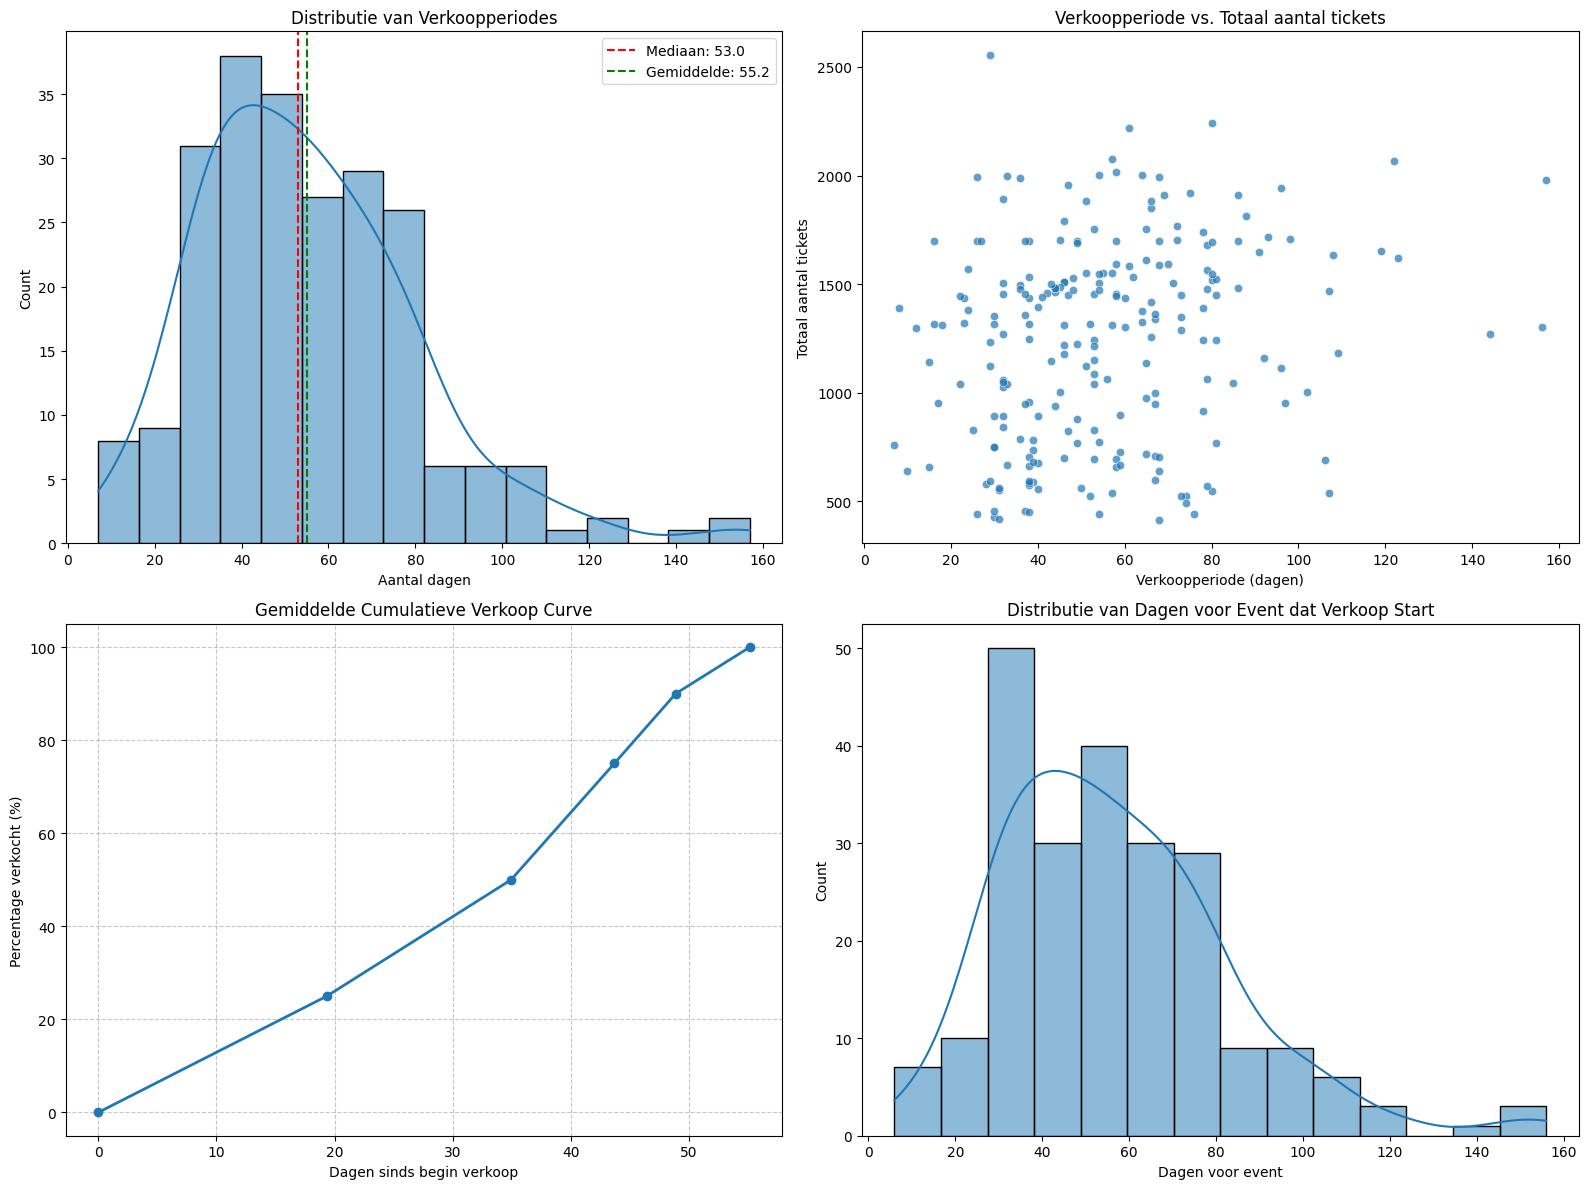

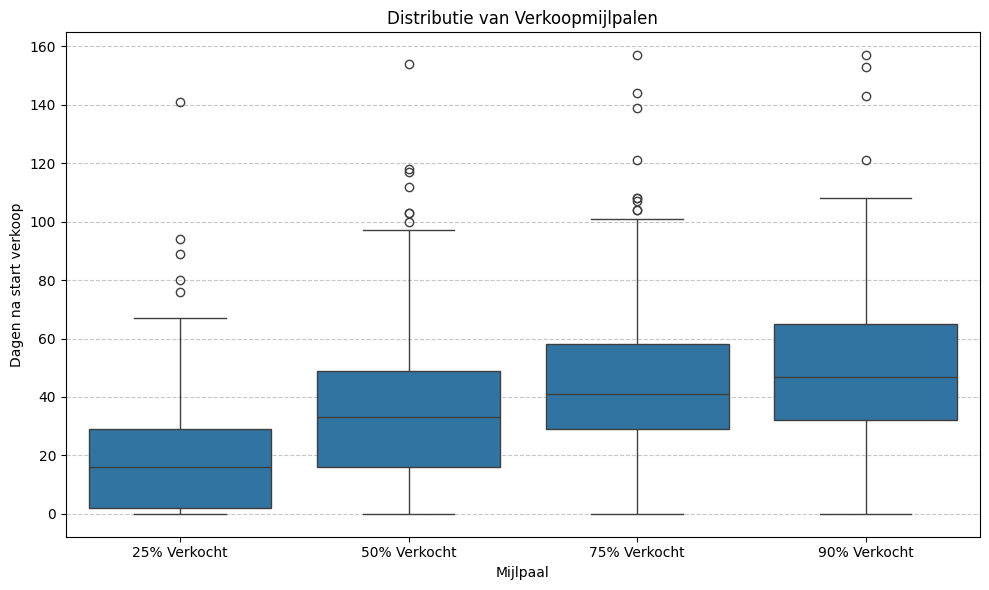

In [5]:
# Analyseren van de verkoopperiodes per event
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Zorg ervoor dat datum kolommen correct zijn
tickets_df['verkoopdatum'] = pd.to_datetime(tickets_df['verkoopdatum'], errors='coerce')
tickets_df['first_event_date_start'] = pd.to_datetime(tickets_df['first_event_date_start'], errors='coerce')

# Bereken statistieken over verkoopperiodes
sales_stats = []

for event in tickets_df['event_name'].unique():
    event_tickets = tickets_df[tickets_df['event_name'] == event]
    
    if 'verkoopdatum' in event_tickets.columns and 'first_event_date_start' in event_tickets.columns:
        # Filter op valide data
        valid_data = event_tickets[event_tickets['verkoopdatum'].notna() & event_tickets['first_event_date_start'].notna()]
        
        if not valid_data.empty:
            # Gebeurtenisdatum en verkoopdatums
            event_date = valid_data['first_event_date_start'].iloc[0]
            first_sale = valid_data['verkoopdatum'].min()
            last_sale = valid_data['verkoopdatum'].max()
            
            # Bereken verkoopperiode en dagen tot event
            sales_period_days = (last_sale - first_sale).days
            days_before_event = (event_date - first_sale).days
            total_tickets = len(valid_data)
            
            # Bereken wanneer verschillende percentages van de kaarten verkocht waren
            ticket_dates = valid_data['verkoopdatum'].sort_values().reset_index(drop=True)
            pct_25_idx = int(len(ticket_dates) * 0.25)
            pct_50_idx = int(len(ticket_dates) * 0.50)
            pct_75_idx = int(len(ticket_dates) * 0.75)
            pct_90_idx = int(len(ticket_dates) * 0.90)
            
            if pct_90_idx >= len(ticket_dates):
                pct_90_idx = len(ticket_dates) - 1
            
            days_to_25pct = (ticket_dates[pct_25_idx] - first_sale).days
            days_to_50pct = (ticket_dates[pct_50_idx] - first_sale).days
            days_to_75pct = (ticket_dates[pct_75_idx] - first_sale).days
            days_to_90pct = (ticket_dates[pct_90_idx] - first_sale).days
            
            # Gemiddelde dagelijkse verkopen
            avg_daily_sales = total_tickets / max(1, sales_period_days)
            
            # Als we de data hebben voor eerdere stadia, bereken het ook
            stats_dict = {
                'event_name': event,
                'total_tickets': total_tickets,
                'sales_period_days': sales_period_days,
                'days_before_event': days_before_event,
                'days_to_25pct': days_to_25pct,
                'days_to_50pct': days_to_50pct,
                'days_to_75pct': days_to_75pct,
                'days_to_90pct': days_to_90pct,
                'avg_daily_sales': avg_daily_sales,
            }
            
            sales_stats.append(stats_dict)

# Converteer naar DataFrame en visualiseer
if sales_stats:
    sales_stats_df = pd.DataFrame(sales_stats)
    
    # Basic stats
    print("\n=== Verkoopperiode Statistieken ===")
    print(f"Aantal geanalyseerde events: {len(sales_stats_df)}")
    print(f"Gemiddelde verkoopperiode: {sales_stats_df['sales_period_days'].mean():.1f} dagen")
    print(f"Mediaan verkoopperiode: {sales_stats_df['sales_period_days'].median():.1f} dagen")
    print(f"Minimum verkoopperiode: {sales_stats_df['sales_period_days'].min():.1f} dagen")
    print(f"Maximum verkoopperiode: {sales_stats_df['sales_period_days'].max():.1f} dagen")
    
    print("\n=== Hoeveel dagen van tevoren begint verkoop? ===")
    print(f"Gemiddeld: {sales_stats_df['days_before_event'].mean():.1f} dagen voor event")
    print(f"Mediaan: {sales_stats_df['days_before_event'].median():.1f} dagen voor event")
    
    print("\n=== Wanneer zijn de belangrijke verkoopmomenten? ===")
    print(f"Gemiddeld aantal dagen tot 25% verkocht: {sales_stats_df['days_to_25pct'].mean():.1f} dagen")
    print(f"Gemiddeld aantal dagen tot 50% verkocht: {sales_stats_df['days_to_50pct'].mean():.1f} dagen")
    print(f"Gemiddeld aantal dagen tot 75% verkocht: {sales_stats_df['days_to_75pct'].mean():.1f} dagen")
    print(f"Gemiddeld aantal dagen tot 90% verkocht: {sales_stats_df['days_to_90pct'].mean():.1f} dagen")

    # Visualisaties
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Histogram van verkoopperiodes
    sns.histplot(sales_stats_df['sales_period_days'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distributie van Verkoopperiodes')
    axes[0, 0].set_xlabel('Aantal dagen')
    axes[0, 0].axvline(sales_stats_df['sales_period_days'].median(), color='r', linestyle='--', label=f'Mediaan: {sales_stats_df["sales_period_days"].median():.1f}')
    axes[0, 0].axvline(sales_stats_df['sales_period_days'].mean(), color='g', linestyle='--', label=f'Gemiddelde: {sales_stats_df["sales_period_days"].mean():.1f}')
    axes[0, 0].legend()
    
    # 2. Verkoopperiode vs Totaal aantal tickets
    sns.scatterplot(data=sales_stats_df, x='sales_period_days', y='total_tickets', ax=axes[0, 1], alpha=0.7)
    axes[0, 1].set_title('Verkoopperiode vs. Totaal aantal tickets')
    axes[0, 1].set_xlabel('Verkoopperiode (dagen)')
    axes[0, 1].set_ylabel('Totaal aantal tickets')
    
    # 3. Cumulatieve sales curve (gemiddeld)
    axes[1, 0].plot([0, sales_stats_df['days_to_25pct'].mean(), sales_stats_df['days_to_50pct'].mean(), 
                     sales_stats_df['days_to_75pct'].mean(), sales_stats_df['days_to_90pct'].mean(), 
                     sales_stats_df['sales_period_days'].mean()],
                     [0, 25, 50, 75, 90, 100], 'o-', linewidth=2)
    axes[1, 0].set_title('Gemiddelde Cumulatieve Verkoop Curve')
    axes[1, 0].set_xlabel('Dagen sinds begin verkoop')
    axes[1, 0].set_ylabel('Percentage verkocht (%)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    
    # 4. Histogram van wanneer verkoop start t.o.v. event datum
    sns.histplot(sales_stats_df['days_before_event'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distributie van Dagen voor Event dat Verkoop Start')
    axes[1, 1].set_xlabel('Dagen voor event')
    
    plt.tight_layout()
    plt.show()
    
    # Extra visualisatie: Box plot voor verschillende mijlpalen in de verkoop
    plt.figure(figsize=(10, 6))
    milestone_data = pd.DataFrame({
        'Dagen': [
            sales_stats_df['days_to_25pct'],
            sales_stats_df['days_to_50pct'],
            sales_stats_df['days_to_75pct'],
            sales_stats_df['days_to_90pct'],
        ],
        'Mijlpaal': [
            '25% Verkocht',
            '50% Verkocht',
            '75% Verkocht',
            '90% Verkocht',
        ]
    })
    
    sns.boxplot(x='Mijlpaal', y='Dagen', data=milestone_data.explode('Dagen').reset_index(drop=True))
    plt.title('Distributie van Verkoopmijlpalen')
    plt.ylabel('Dagen na start verkoop')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Geen geldige verkoopdata om te analyseren.")

## 1. Helper functies voor snapshots

Dit zijn functies om een 'snapshot' te maken van een event op een bepaald aantal dagen voor de event-datum. We hergebruiken deze uit het oude dual model.

In [6]:
def compute_days_until_event(ticket_data: pd.DataFrame, reference_date=None) -> pd.DataFrame:
    """
    Voegt kolom 'days_until_event' toe als het verschil in dagen tussen
    first_event_date_start en reference_date.
    """
    data = ticket_data.copy()
    
    # Zet reference_date om in pd.Timestamp
    if reference_date is None:
        ref_ts = pd.Timestamp(datetime.now().date())
    else:
        ref_ts = pd.to_datetime(reference_date)
    
    # Zorg dat first_event_date_start datetime is
    data['first_event_date_start'] = pd.to_datetime(
        data['first_event_date_start'], errors='coerce'
    )
    # Bereken verschil in dagen
    data['days_until_event'] = (data['first_event_date_start'] - ref_ts).dt.days
    return data

def build_event_snapshot(ticket_data: pd.DataFrame, event_name: str, reference_date=None) -> dict:
    """
    Bouwt een snapshot dict voor één event op de gegeven reference_date.
    Berekent total_tickets, tickets_remaining en tickets_nextweek als targets.
    """
    # Zet reference om in Timestamp
    if reference_date is None:
        ref_ts = pd.Timestamp(datetime.now().date())
    else:
        ref_ts = pd.to_datetime(reference_date)
    end_ts = ref_ts + pd.Timedelta(days=7)
    
    # Filter event
    df = ticket_data[ticket_data['event_name']==event_name].copy()
    if df.empty:
        raise ValueError(f"No data for event '{event_name}'")
    
    # days_until_event
    df = compute_days_until_event(df, reference_date)
    
    # verkoopdatum datetime
    if 'verkoopdatum' in df.columns:
        df['verkoopdatum'] = pd.to_datetime(df['verkoopdatum'], errors='coerce')
    else:
        # fallback: alle rijen vóór ref tellen
        df['verkoopdatum'] = ref_ts
    
    # Total tickets (totaal aantal tickets voor het event)
    total = len(df)
    # Aantal verkocht tot en met ref_ts
    sold_to_date = df[df['verkoopdatum'] <= ref_ts].shape[0]
    # Remaining (tickets_remaining) - dit is berekend uit total - sold_to_date
    tickets_remaining = total - sold_to_date
    # Verkopen in de komende 7 dagen (tickets_nextweek) - dit is onze tweede target
    tickets_nextweek = df[
        (df['verkoopdatum'] > ref_ts) &
        (df['verkoopdatum'] <= end_ts)
    ].shape[0]
    
    return {
        'event_name':        event_name,
        'reference_date':    ref_ts,
        'days_until_event':  int(df['days_until_event'].iloc[0]),
        'total_tickets':     total,                # Totaal aantal tickets (strategisch model)
        'buyers_so_far':     sold_to_date,
        'tickets_remaining': tickets_remaining,    # Berekend uit total - sold_to_date
        'tickets_nextweek':  tickets_nextweek      # Voor tactisch model
    }

In [7]:
def make_dataset_snapshot(
    ticket_data: pd.DataFrame,
    lineup_data: pd.DataFrame = None,
    artists_data: pd.DataFrame = None,
    forecast_days: int = 7
) -> pd.DataFrame:
    """
    Bouwt voor álle events een snapshot op T dagen voor elk event.
    """
    snapshots = []
    # zorg dat event_date kolom datetime is
    ticket_data['first_event_date_start'] = pd.to_datetime(
        ticket_data['first_event_date_start'], errors='coerce'
    )

    for event in ticket_data['event_name'].unique():
        # subselect: alle tickets voor precies dit event
        ev = ticket_data[ticket_data['event_name'] == event]
        if ev.empty: 
            continue

        # bepaal event_date
        event_date = ev['first_event_date_start'].iloc[0].date()
        # per-event referentiedatum
        ref_date = event_date - pd.Timedelta(days=forecast_days)

        snap = build_event_snapshot(
            ticket_data, 
            event_name=event, 
            reference_date=ref_date
        )
        snapshots.append(snap)

    return pd.DataFrame(snapshots)



=== Aanmaken Multi-Snapshot Dataset ===
Dagen voor event: 7 tot 121, stap: 7 dagen
Verwerking event 10/227...
Verwerking event 10/227...
Verwerking event 20/227...
Verwerking event 20/227...
Verwerking event 30/227...
Verwerking event 30/227...
Verwerking event 40/227...
Verwerking event 40/227...
Verwerking event 50/227...
Verwerking event 50/227...
Verwerking event 60/227...
Verwerking event 60/227...
Verwerking event 70/227...
Verwerking event 70/227...
Verwerking event 80/227...
Verwerking event 80/227...
Verwerking event 90/227...
Verwerking event 90/227...
Verwerking event 100/227...
Verwerking event 100/227...
Verwerking event 110/227...
Verwerking event 110/227...
Verwerking event 120/227...
Verwerking event 120/227...
Verwerking event 130/227...
Verwerking event 130/227...
Verwerking event 140/227...
Verwerking event 140/227...
Verwerking event 150/227...
Verwerking event 150/227...
Verwerking event 160/227...
Verwerking event 160/227...
Verwerking event 170/227...
Verwerking 

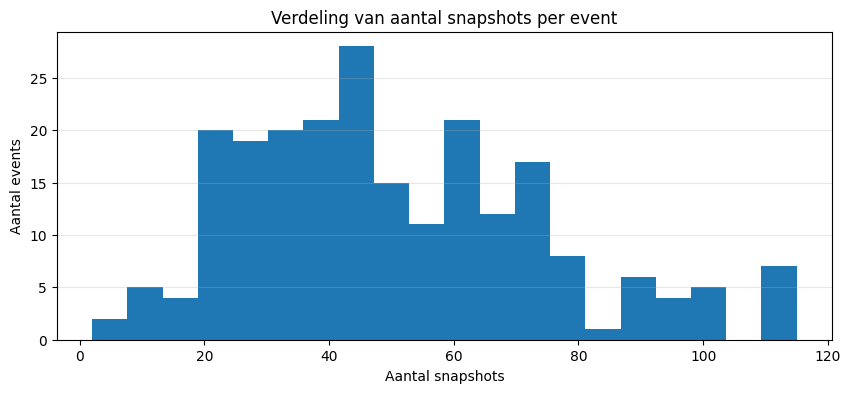

In [8]:
def make_multi_snapshot_dataset(
    ticket_data: pd.DataFrame,
    lineup_data: pd.DataFrame = None,
    artists_data: pd.DataFrame = None,
    min_days_before: int = 7,
    max_days_before: int = 121,
    step_days: int = 7
) -> pd.DataFrame:
    """
    Bouwt snapshots op meerdere tijdstippen voor alle events.
    Voor elk event worden snapshots gemaakt op verschillende momenten
    (bijv. T=7, 14, 21, ... dagen voor het event).
    
    Args:
        ticket_data: DataFrame met ticketdata
        lineup_data: Optioneel, DataFrame met lineup data
        artists_data: Optioneel, DataFrame met artist data
        min_days_before: Minimaal aantal dagen voor event om snapshot te maken
        max_days_before: Maximaal aantal dagen voor event om snapshot te maken
        step_days: Stapgrootte in dagen tussen snapshots
        
print(f"Datasets geladen:")
print(f"- tickets_processed.csv: {tickets_df.shape[0]} rijen, {tickets_df.shape[1]} kolommen")
print(f"- line_up_processed.csv: {lineup_df.shape[0]} rijen, {lineup_df.shape[1]} kolommen")
print(f"- artist_insights.csv: {artists_df.shape[0]} rijen, {artists_df.shape[1]} kolommen")
    Returns:
        DataFrame met snapshots op diverse tijdspunten met tickets_nextweek targets
    """
    print(f"=== Aanmaken Multi-Snapshot Dataset ===")
    print(f"Dagen voor event: {min_days_before} tot {max_days_before}, stap: {step_days} dagen")
    
    # Zorg dat event_date kolom datetime is
    ticket_data['first_event_date_start'] = pd.to_datetime(
        ticket_data['first_event_date_start'], errors='coerce'
    )
    
    all_snapshots = []
    total_events = len(ticket_data['event_name'].unique())
    event_count = 0
    valid_event_count = 0
    snapshot_count = 0
    
    for event in ticket_data['event_name'].unique():
        event_count += 1
        if event_count % 10 == 0:
            print(f"Verwerking event {event_count}/{total_events}...")
            
        # Subselect: alle tickets voor precies dit event
        ev = ticket_data[ticket_data['event_name'] == event]
        if ev.empty: 
            continue
            
        # Bepaal event_date
        if ev['first_event_date_start'].isna().all():
            continue
            
        event_date = ev['first_event_date_start'].iloc[0]
        
        # Bereken verkoopduren vóór event_date
        if 'verkoopdatum' in ev.columns and ev['verkoopdatum'].notna().any():
            # Ensure verkoopdatum is datetime
            if not pd.api.types.is_datetime64_dtype(ev['verkoopdatum']):
                ev['verkoopdatum'] = pd.to_datetime(ev['verkoopdatum'], errors='coerce')
            
            first_sale_date = ev['verkoopdatum'].min()
            days_of_sales = (event_date - first_sale_date).days
        else:
            continue  # Skip events zonder verkoopdatum
            
        valid_event_count += 1
        
        # Genereer snapshots op verschillende dagen voor het event
        for days_before in range(min_days_before, min(max_days_before + 1, days_of_sales + 1), step_days):
            ref_date = event_date - pd.Timedelta(days=days_before)
            
            # Check of de reference date na de eerste verkoopdatum ligt
            # No need to call .date() since both are already datetime objects
            if ref_date <= first_sale_date:
                continue
                
            try:
                # Maak snapshot op deze reference date
                snap = build_event_snapshot(
                    ticket_data, 
                    event_name=event, 
                    reference_date=ref_date
                )
                
                # Voeg extra info toe aan snapshot
                snap['days_before_event'] = days_before
                snap['snapshot_date'] = ref_date
                snap['first_sale_date'] = first_sale_date
                snap['days_since_first_sale'] = (ref_date - first_sale_date).days
                snap['pct_time_elapsed'] = snap['days_since_first_sale'] / max(1, days_of_sales) * 100
                
                all_snapshots.append(snap)
                snapshot_count += 1
            except Exception as e:
                print(f"Fout bij snapshots voor event '{event}': {e}")
                continue
    
    if not all_snapshots:
        print("Geen geldige snapshots gegenereerd!")
        return pd.DataFrame()
        
    # Combineer alle snapshots in één DataFrame
    snapshots_df = pd.DataFrame(all_snapshots)
    
    print(f"Multi-snapshot dataset gecreëerd:")
    print(f"- Verwerkt: {event_count} events")
    print(f"- Geldige events: {valid_event_count}")
    print(f"- Totaal snapshots: {snapshot_count}")
    print(f"- Gemiddeld {snapshot_count/valid_event_count:.1f} snapshots per event")
    print(f"- Dataset vorm: {snapshots_df.shape}")
    
    return snapshots_df

# Test de multi-snapshot functie met verschillende instellingen
# 1) Voor wekelijkse snapshots, T=7 tot T=56
multi_snap_weekly = make_multi_snapshot_dataset(
    tickets_df,
    min_days_before=7,
    max_days_before=121,  # 8 weken
    step_days=7          # Wekelijkse stappen
)
print(multi_snap_weekly[['event_name','days_before_event','tickets_nextweek','snapshot_date']].head(10))

# Create daily snapshots from 7 days to 56 days before the event
multi_snap_daily = make_multi_snapshot_dataset(
    tickets_df,
    min_days_before=7,       # Start 7 days before event
    max_days_before=121,      # Up to 8 weeks before event
    step_days=1              # Daily snapshots instead of weekly
)

print(f"Aantal dagelijkse snapshots: {len(multi_snap_daily)}")
print(multi_snap_daily[['event_name','days_before_event','tickets_nextweek','snapshot_date']].head(15))

# Analyse de verdelingen van snapshots per event
snap_per_event = multi_snap_daily.groupby('event_name').size().reset_index(name='aantal_snapshots')
print(f"\nSamenvatting snapshots per event:")
print(f"- Min: {snap_per_event['aantal_snapshots'].min()}")
print(f"- Mediaan: {snap_per_event['aantal_snapshots'].median()}")
print(f"- Gemiddeld: {snap_per_event['aantal_snapshots'].mean():.1f}")
print(f"- Max: {snap_per_event['aantal_snapshots'].max()}")

# Plot histogram van snapshots per event
plt.figure(figsize=(10, 4))
plt.hist(snap_per_event['aantal_snapshots'], bins=20)
plt.title('Verdeling van aantal snapshots per event')
plt.xlabel('Aantal snapshots')
plt.ylabel('Aantal events')
plt.grid(axis='y', alpha=0.3)
plt.show()



## 1.5 Feature Engineering functie voor tactisch model

Deze functie is een aangepaste versie van de `engineer_features` functie uit strategic_model.ipynb, speciaal ontworpen voor het tactische model dat voorspelt hoeveel tickets er in de komende week worden verkocht.

In [9]:
from typing import Optional, List
from sklearn.model_selection import GroupKFold


def engineer_tactical_features(
    tickets: pd.DataFrame,
    line_up_df: pd.DataFrame = None,
    artists_df: pd.DataFrame = None,
    facebook_df: pd.DataFrame = None,  # Nieuwe parameter
    forecast_days: int = 7,
    known_cities: Optional[List[str]] = None,
    max_lag: int = 3,
    reference_date = None,  
    verbose: bool = True
) -> pd.DataFrame:
    """
    Generates a set of features specifically for the tactical model (predicting tickets_nextweek).
    This function is based on engineer_features from Ticket_model_copy_7, but:
    - Does not compute the target (tickets_nextweek comes from snapshot data)
    - Focuses on short-term dynamic features
    - Adds extra features about recent sales and sales acceleration
    - Removes features less relevant for short-term predictions
    - STRICTLY enforces reference date cutoffs to prevent data leakage
    - NOW INCLUDES: Facebook marketing features
    
    Parameters:
    -----------
    tickets: DataFrame with ticket data
    line_up_df: DataFrame with lineup data (optional)
    artists_df: DataFrame with artist data (optional)
    facebook_df: DataFrame with Facebook posts data (optional)
    forecast_days: Number of days to forecast ahead
    known_cities: List of standardized city names
    max_lag: Maximum lag for sales features
    reference_date: Explicit reference date to use for all events (optional)
                   If None, will calculate from event_date - forecast_days
    verbose: Print detailed information
    
    IMPORTANT: Ensures that the `sales_last_7_days` feature is not identical to the
    `tickets_nextweek` target by using historical sales data BEFORE reference date
    instead of future data after reference date.
    """

    debug_print(f"\n--- Start Tactical Feature Engineering (T={forecast_days}) ---", verbose)
    function_name = "engineer_tactical_features" 

    # Step 1: Basic Preprocessing
    debug_print(f"[{function_name}] Step 1: Basic Preprocessing...", verbose)
    tickets = tickets.copy()
    line_up_df = line_up_df.copy() if line_up_df is not None else pd.DataFrame()
    artists_df = artists_df.copy() if artists_df is not None else pd.DataFrame()
    facebook_df = facebook_df.copy() if facebook_df is not None else pd.DataFrame()

    if 'event_name' not in tickets.columns:
        debug_print("FATAL: 'event_name' column is essential and not found.", verbose)
        return pd.DataFrame() 
    tickets['event_name'] = tickets['event_name'].astype(str).apply(normalize_text)

    # Ensure date columns are in datetime format
    date_columns = ['verkoopdatum', 'first_event_date_start', 'last_event_date_end', 'event_date']
    for col in date_columns:
        if col in tickets.columns: 
            tickets[col] = pd.to_datetime(tickets[col], errors='coerce')

    # Standardize city names if available
    if known_cities is not None and 'city' in tickets.columns:
        tickets = standardize_city_names(tickets, known_cities, verbose=False)
    else: 
        tickets['city_standardized'] = 'other'

    # Calculate days_until_event for each ticket - FIX: Avoid inplace on copy
    if {'first_event_date_start', 'verkoopdatum'}.issubset(tickets.columns) and pd.api.types.is_datetime64_any_dtype(tickets['first_event_date_start']) and pd.api.types.is_datetime64_any_dtype(tickets['verkoopdatum']):
        tickets['days_until_event'] = (tickets['first_event_date_start'] - tickets['verkoopdatum']).dt.days
        valid_days_mask = tickets['days_until_event'].notna()
    else: 
        tickets['days_until_event'] = forecast_days
        valid_days_mask = pd.Series(True, index=tickets.index)
    # FIX: Use proper assignment instead of inplace
    tickets['days_until_event'] = tickets['days_until_event'].fillna(forecast_days)

    # Create per-event reference dates (critical for preventing data leakage)
    event_ref_dates = {}
    

    if reference_date is not None:
        ref_date = pd.to_datetime(reference_date)
        for event_name in tickets['event_name'].unique():
            event_ref_dates[event_name] = ref_date
        debug_print(f"[{function_name}] Using provided reference_date {ref_date} for all events", verbose)
    else:
        # If no reference_date provided, calculate per-event (original logic)
        for event_name in tickets['event_name'].unique():
            event_data = tickets[tickets['event_name'] == event_name]
            if 'first_event_date_start' in event_data.columns and event_data['first_event_date_start'].notna().any():
                event_date = event_data['first_event_date_start'].iloc[0]
                ref_date = event_date - pd.Timedelta(days=forecast_days)
                event_ref_dates[event_name] = ref_date
    
    debug_print(f"[{function_name}] Created reference dates for {len(event_ref_dates)} events", verbose)
    
    
    # Use more efficient vectorized approach instead of apply with lambda
    tickets_before_ref = pd.DataFrame()
    
    for event_name, ref_date in event_ref_dates.items():
        event_tickets = tickets[tickets['event_name'] == event_name]
        valid_tickets = event_tickets[event_tickets['verkoopdatum'] <= ref_date]
        tickets_before_ref = pd.concat([tickets_before_ref, valid_tickets])
    
    debug_print(f"[{function_name}] Filtered from {len(tickets)} to {len(tickets_before_ref)} tickets (data leakage prevention)", verbose)

    # Work with events for which we have data
    df_tactical = pd.DataFrame({'event_name': list(event_ref_dates.keys())})

    # Step 2: Tactical Sales Features using strictly time-bounded data
    debug_print(f"[{function_name}] Step 2: Tactical Sales Features...", verbose)

    # Basic set with event_names to work with
    sales_features = pd.DataFrame({'event_name': df_tactical['event_name'].unique()})
    
    # 2.1: Lag features for different periods (1, 3, 7 days) with strict time boundaries

    lag_periods = [1, 3, 7] # Days back for lag features
    
    for lag_days in lag_periods:
       
        # This makes it clear that we're looking at past sales BEFORE reference date, not future sales
        lag_sales_col = f'sales_before_ref_{lag_days}_days'
        log_lag_sales_col = f'log_{lag_sales_col}'
        
        # For each event, calculate sales in the last X days BEFORE reference date
        lag_sales = []
        for event_name in sales_features['event_name']:
            if event_name in event_ref_dates:
                ref_date = event_ref_dates[event_name]
                lag_start = ref_date - pd.Timedelta(days=lag_days)
                
                # Count tickets sold between lag_start and ref_date (past data only)

                event_tickets = tickets_before_ref[tickets_before_ref['event_name'] == event_name]
                lag_count = event_tickets[
                    (event_tickets['verkoopdatum'] > lag_start) & 
                    (event_tickets['verkoopdatum'] <= ref_date)
                ].shape[0]
                
                lag_sales.append({'event_name': event_name, lag_sales_col: lag_count})
        
        lag_df = pd.DataFrame(lag_sales)
        sales_features = pd.merge(sales_features, lag_df, on='event_name', how='left')
        sales_features[lag_sales_col] = sales_features[lag_sales_col].fillna(0)
        sales_features[log_lag_sales_col] = np.log1p(sales_features[lag_sales_col])

    # 2.2: Cumulative sales up to reference date (not T)
    cumulative_sales = []
    for event_name in sales_features['event_name']:
        if event_name in event_ref_dates:
            ref_date = event_ref_dates[event_name]
            
            # Count all tickets sold up to and including reference date
            event_tickets = tickets_before_ref[tickets_before_ref['event_name'] == event_name]
            cum_count = len(event_tickets)
            
            cumulative_sales.append({
                'event_name': event_name, 
                'cumulative_sales_at_t': cum_count
            })
    
    if cumulative_sales:
        cum_df = pd.DataFrame(cumulative_sales)
        sales_features = pd.merge(sales_features, cum_df, on='event_name', how='left')
        sales_features['cumulative_sales_at_t'] = sales_features['cumulative_sales_at_t'].fillna(0)
        sales_features['log_cumulative_sales_at_t'] = np.log1p(sales_features['cumulative_sales_at_t'])
        
        # 2.3: Average daily sales up to reference date
        avg_daily_sales = []
        for event_name in sales_features['event_name']:
            if event_name in event_ref_dates:
                ref_date = event_ref_dates[event_name]
                event_tickets = tickets_before_ref[
                    (tickets_before_ref['event_name'] == event_name) & 
                    (tickets_before_ref['verkoopdatum'] <= ref_date)
                ]
                
                if len(event_tickets) > 0:
                    # Find first sale date for this event
                    first_sale_date = event_tickets['verkoopdatum'].min()
                    if pd.notna(first_sale_date):
                        # Calculate days of sales (add 1 to include the first day)
                        sales_days = (ref_date - first_sale_date).days + 1
                        # If sales occurred on same day, use 1 day minimum
                        sales_days = max(1, sales_days)
                        avg_daily = len(event_tickets) / sales_days
                    else:
                        avg_daily = 0
                else:
                    avg_daily = 0
                
                avg_daily_sales.append({
                    'event_name': event_name,
                    'avg_daily_sales_before_t': avg_daily
                })
        
        avg_df = pd.DataFrame(avg_daily_sales)
        sales_features = pd.merge(sales_features, avg_df, on='event_name', how='left')
        sales_features['avg_daily_sales_before_t'] = sales_features['avg_daily_sales_before_t'].fillna(0)
        sales_features['log_avg_daily_sales_before_t'] = np.log1p(sales_features['avg_daily_sales_before_t'])
        
        # 2.4: Sales acceleration (using strictly bounded data)
        if 'sales_before_ref_3_days' in sales_features.columns and 'sales_before_ref_7_days' in sales_features.columns:
            sales_features['sales_days_4_to_7'] = sales_features['sales_before_ref_7_days'] - sales_features['sales_before_ref_3_days']
            sales_features['sales_days_4_to_7'] = sales_features['sales_days_4_to_7'].clip(lower=0)
            
            sales_features['recent_sales_acceleration'] = sales_features['sales_before_ref_3_days'] - sales_features['sales_days_4_to_7']

    # 2.5: Tactical ratio features - FIX: Ensure proper dtype handling
    if 'sales_before_ref_3_days' in sales_features.columns and 'cumulative_sales_at_t' in sales_features.columns:
        # Initialize as float64 to avoid dtype warnings
        sales_features['ratio_recent_vs_total'] = 0.0
        mask_nonzero_cum = sales_features['cumulative_sales_at_t'] > 0
        sales_features.loc[mask_nonzero_cum, 'ratio_recent_vs_total'] = (
            sales_features.loc[mask_nonzero_cum, 'sales_before_ref_3_days'].astype(float) / 
            sales_features.loc[mask_nonzero_cum, 'cumulative_sales_at_t'].astype(float)
        )
    

    if 'sales_before_ref_7_days' in sales_features.columns and 'sales_before_ref_3_days' in sales_features.columns:
        # Initialize as float64 to avoid dtype warnings
        sales_features['ratio_week_vs_recent'] = 0.0
        mask_nonzero_recent = sales_features['sales_before_ref_3_days'] > 0
        sales_features.loc[mask_nonzero_recent, 'ratio_week_vs_recent'] = (
            sales_features.loc[mask_nonzero_recent, 'sales_before_ref_7_days'].astype(float) / 
            sales_features.loc[mask_nonzero_recent, 'sales_before_ref_3_days'].astype(float)
        ).clip(0, 10)  # Clip extreme ratios

    # Step 3: Time-based Features using proper reference dates
    debug_print(f"[{function_name}] Step 3: Time Features...", verbose)
    time_features_list = []
    
    for event_name in sales_features['event_name']:
        if event_name in event_ref_dates:
            event_data = tickets_before_ref[tickets_before_ref['event_name'] == event_name]
            ref_date = event_ref_dates[event_name]
            event_date = ref_date + pd.Timedelta(days=forecast_days)
            
            # Use only sales data up to reference date
            valid_sales = event_data
            first_sale_date = valid_sales['verkoopdatum'].min() if not valid_sales.empty else None
            
            feature_dict = {
                'event_name': event_name,
                'day_of_week': event_date.dayofweek if pd.notna(event_date) else -1,
                'event_month': event_date.month if pd.notna(event_date) else -1,
                'event_year': event_date.year if pd.notna(event_date) else -1,
            }
            
            feature_dict['is_weekend'] = int(feature_dict['day_of_week'] in [5, 6])
            feature_dict['month_sin'] = np.sin(2 * np.pi * feature_dict['event_month']/12)
            feature_dict['month_cos'] = np.cos(2 * np.pi * feature_dict['event_month']/12)
            feature_dict['day_of_week_sin'] = np.sin(2 * np.pi * feature_dict['day_of_week']/7)
            feature_dict['day_of_week_cos'] = np.cos(2 * np.pi * feature_dict['day_of_week']/7)
            
            # Days since first sale (using only valid sales data)
            if pd.notna(first_sale_date):
                feature_dict['days_since_first_sale'] = (ref_date - first_sale_date).days
                feature_dict['days_since_first_sale'] = max(0, feature_dict['days_since_first_sale'])
                feature_dict['log_days_since_first_sale'] = np.log1p(feature_dict['days_since_first_sale'])
                
                # Estimate total sales period
                feature_dict['est_total_sales_period'] = (event_date - first_sale_date).days
                feature_dict['est_total_sales_period'] = max(1, feature_dict['est_total_sales_period'])
                
                # Percentage of sales period elapsed
                feature_dict['pct_sales_period_elapsed'] = (
                    feature_dict['days_since_first_sale'] / feature_dict['est_total_sales_period']
                )
                feature_dict['pct_sales_period_elapsed'] = min(1.0, max(0.0, feature_dict['pct_sales_period_elapsed']))

                # === Verkoopcurve features ===
                pct = feature_dict['pct_sales_period_elapsed']
                # Sales phase
                if pct < 0.25:
                    feature_dict['sales_phase'] = 'early'
                elif pct < 0.5:
                    feature_dict['sales_phase'] = 'mid'
                elif pct < 0.75:
                    feature_dict['sales_phase'] = 'late'
                else:
                    feature_dict['sales_phase'] = 'sprint'
                # Binned features
                days_before_event = (event_date - ref_date).days
                feature_dict['is_last_week'] = int(days_before_event <= 7)
                feature_dict['is_last_3_days'] = int(days_before_event <= 3)
                # Interactie features 
                s3 = sales_features.loc[sales_features['event_name'] == event_name, 'sales_before_ref_3_days']
                s7 = sales_features.loc[sales_features['event_name'] == event_name, 'sales_before_ref_7_days']
                feature_dict['pct_elapsed_x_sales3'] = pct * (s3.values[0] if not s3.empty else 0)
                feature_dict['pct_elapsed_x_sales7'] = pct * (s7.values[0] if not s7.empty else 0)
            
            time_features_list.append(feature_dict)
    
    time_features_df = pd.DataFrame(time_features_list)
    time_features_df['forecast_days'] = forecast_days
    
    # Step 4: Combine all tactical features
    debug_print(f"[{function_name}] Step 4: Combine features...", verbose)
    
    # Merge sales and time features
    if time_features_df.empty:
        df_tactical = sales_features.copy()
    else:
        df_tactical = pd.merge(sales_features, time_features_df, on='event_name', how='left')

    # Fill nulls for numeric columns
    for col in df_tactical.columns:
        if col != 'event_name' and pd.api.types.is_numeric_dtype(df_tactical[col]):
            df_tactical[col] = df_tactical[col].fillna(0)
    
    # Step 4: Facebook Marketing Features
    debug_print(f"[{function_name}] Step 4: Facebook Marketing Features...", verbose)
    if not facebook_df.empty:
        # Filter Facebook data to include only posts before the reference date
        facebook_df['post_date'] = pd.to_datetime(facebook_df['post_date'], errors='coerce')
        facebook_df = facebook_df[facebook_df['post_date'] <= reference_date]
        
        # Aggregate Facebook metrics for the last 3 days
        facebook_df['days_since_post'] = (reference_date - facebook_df['post_date']).dt.days
        recent_posts = facebook_df[facebook_df['days_since_post'] <= 3]
        
        # Calculate features
        posts_last_3d = recent_posts.groupby('event_name').size().reindex(df_tactical['event_name'], fill_value=0)
        log_posts_last_3d = np.log1p(posts_last_3d)
        
        # Add features to the tactical DataFrame
        df_tactical['posts_last_3d'] = posts_last_3d
        df_tactical['log_posts_last_3d'] = log_posts_last_3d
    else:
        # Add dummy columns if no Facebook data is available
        df_tactical['posts_last_3d'] = 0
        df_tactical['log_posts_last_3d'] = 0
        debug_print(f"[{function_name}] Geen Facebook data beschikbaar, dummy features toegevoegd", verbose)
    
    return df_tactical

In [10]:
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial

def run_tactical_model_comparison(
    df: pd.DataFrame,
    T: int = 7,
    verbose: bool = True
):
    """
    Voert modelvergelijking uit specifiek voor het tactische model (tickets_nextweek):
    - Aangepaste feature selectie gericht op korte-termijn predictie features
    - Speciaal voor wekelijkse ticketvoorspellingen (kleinere aantallen)
    - Aangepaste foutenanalyse categorieën voor wekelijkse verkopen
    - Verbeterd met event-based splitting om data leakage te voorkomen

    Returns:
        summary_df: DataFrame with model comparison results
        best_model_name: Name of the best performing model
        best_model_pipeline: The trained model pipeline
        did_log_transform: Whether a log transform was applied to the target
        best_is_poisson: Whether the winning model used a Poisson objective
    """
    # Logging
    debug_print(f"\n=== Start Tactische Model Comparison (T={T}) ===", verbose)
    target_col = 'full_event_tickets'
    
    # Define custom scorer functions
    def rmse_scorer(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    def rmse_original_scorer(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, np.expm1(y_pred)))
    
    def mae_original_scorer(y_true, y_pred):
        return mean_absolute_error(y_true, np.expm1(y_pred))
    
    def r2_original_scorer(y_true, y_pred):
        return r2_score(y_true, np.expm1(y_pred))
    
    # Check presence of target
    if target_col not in df.columns:
        debug_print(f"Target '{target_col}' niet gevonden.", verbose)
        return None, None, None, False, False
    df = df.dropna(subset=[target_col])
    
    # --- Targets ---
    # y_orig: rauwe tellers, >=0
    y_orig = df[target_col].copy()
    # y_log: gelogde variantie voor MSE-modellen
    y_log = np.log1p(y_orig)
    
  
    drop_leak_cols = ['tickets_nextweek', target_col]
    df = df.drop(columns=[c for c in drop_leak_cols if c in df.columns])

    
    dt_cols = [c for c in df.columns if pd.api.types.is_datetime64_dtype(df[c])]
    for c in dt_cols:
        # Convert datetime features to useful numeric representations
        df[f'{c}_weekday'] = df[c].dt.weekday
        df[f'{c}_month'] = df[c].dt.month
        df[f'{c}_year'] = df[c].dt.year
        # Drop original datetime column after extracting features
        df.drop(columns=c, inplace=True)


    df = df.reset_index(drop=True)  # Just reset index without sorting

    # --- Naïeve Baseline ---
    naive_baseline = {'mae': None, 'rmse': None, 'wape': None, 'r2': None}
    if 'sales_last_7_days' in df.columns or 'sales_last_3_days' in df.columns:
        baseline_col = 'sales_last_7_days' if 'sales_last_7_days' in df.columns else 'sales_last_3_days'
        pred = df[baseline_col].values
        # MAE, RMSE, WAPE, R2 op originele schaal
        mae  = mean_absolute_error(y_orig, pred)
        rmse = rmse_scorer(y_orig, pred)
        wape = np.sum(np.abs(y_orig - pred)) / np.sum(y_orig) * 100
        r2   = r2_score(y_orig, pred)
        naive_baseline = {'mae': mae, 'rmse': rmse, 'wape': wape, 'r2': r2}
        debug_print(
            f"Naïeve Baseline ({baseline_col}): MAE={mae:.2f}, RMSE={rmse:.2f}, WAPE={wape:.2f}%, R²={r2:.4f}",
            verbose
        )
    else:
        debug_print("Kan geen naïeve baseline berekenen (geen sales_last_x kolom).", verbose)

    # --- Preprocessor Pipeline ---
    try:
        event_id_cols = ['event_name', 'event_name_norm', 'reference_date', 'snapshot_date', 
                         'first_sale_date', target_col]
        
        # Make sure we remove any columns that could uniquely identify events
        numerical_features = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) 
                             and c not in event_id_cols]
        categorical_features = [c for c in df.columns if not np.issubdtype(df[c].dtype, np.number) 
                               and c not in event_id_cols
                               and not pd.api.types.is_datetime64_dtype(df[c])]  # Exclude datetime columns
        
        # Log what we're including and excluding
        print("\n--- Feature Selection ---")
        print(f"Excluding event identifiers: {[c for c in df.columns if c in event_id_cols]}")
        print(f"Using {len(numerical_features)} numerical features")
        print(f"Using {len(categorical_features)} categorical features")
        
        # Build a simpler preprocessor with just StandardScaler for numerical features
        num_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  
        ])
        # OneHotEncoder for categorical features
        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        # Create the preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, numerical_features),
                ('cat', cat_transformer, categorical_features)
            ],
            remainder='drop'  # Drop any columns not explicitly included
        )
    except Exception as e:
        debug_print(f"Error creating preprocessor: {e}", verbose)
        return None, None, None, False, False

    # --- Scorers voor Poisson en MSE ---
    # Custom scorer that can handle negative predictions or zeroes
    def custom_poisson_scorer(y_true, y_pred):
        """
        Custom Poisson deviance scorer that properly handles edge cases:
        - Ensures y_true is non-negative
        - Ensures y_pred is strictly positive (required for Poisson)
        - Properly handles potential numerical issues
        """
        # Ensure y_true is non-negative (Poisson requires non-negative counts)
        y_true = np.maximum(y_true, 0)
        
        # Ensure predictions are strictly positive (critical for Poisson)
        # Use a small epsilon that's not too small to cause numerical issues
        y_pred = np.maximum(y_pred, 1e-3)
        
        try:
            return -mean_poisson_deviance(y_true, y_pred)
        except Exception as e:
            # Fallback to MSE if Poisson deviance fails (safer)
            print(f"Warning: Poisson deviance calculation failed ({str(e)}), using MSE instead")
            return -mean_squared_error(y_true, y_pred)
    
    poisson_scorers = {
        'neg_poisson_dev': make_scorer(custom_poisson_scorer, greater_is_better=False),
        'neg_rmse':        make_scorer(rmse_scorer, greater_is_better=False),
        'neg_mae':         'neg_mean_absolute_error',
        'r2':              'r2',
    }
    mse_scorers = {
        'neg_rmse_orig': make_scorer(rmse_original_scorer, greater_is_better=False),
        'neg_mae_orig':  make_scorer(mae_original_scorer,  greater_is_better=False),
        'r2_orig':       make_scorer(r2_original_scorer,  greater_is_better=True),
    }

    # --- Modeldefinities ---
    models = {
        "Lasso": {
            "model": Pipeline([
                ("preprocessor", preprocessor), 
                ("reg", Lasso(random_state=42, max_iter=100000, tol=1e-2, fit_intercept=True, warm_start=True, positive=True)) 
            ]),
            "search_type": "grid",
            "params": {"reg__alpha": np.logspace(-3, 0, 8)},  
            "poisson_model": True
        },
        "Ridge": {
            "model": Pipeline([
                ("preprocessor", preprocessor), 
                ("reg", Ridge(random_state=42, max_iter=100000, tol=1e-2, fit_intercept=True, positive=True))  
            ]),
            "search_type": "grid",
            "params": {"reg__alpha": np.logspace(-2, 2, 10)},  
            "poisson_model": True
        },
        "ElasticNet": {
            "model": Pipeline([
                ("preprocessor", preprocessor), 
                ("reg", ElasticNet(random_state=42, max_iter=100000, tol=1e-2, fit_intercept=True, warm_start=True, positive=True))  
            ]),
            "search_type": "grid",
            "params": {"reg__alpha": np.logspace(-2, 0, 5), "reg__l1_ratio": [0.1, 0.5, 0.9]},  
            "poisson_model": True
        },
        "RandomForest": {
            "model": Pipeline([("preprocessor", preprocessor), ("reg", RandomForestRegressor(random_state=42, n_jobs=-1, min_samples_leaf=5))]),
            "search_type": "random",
            "params": {"reg__n_estimators": [100, 200], "reg__max_depth": [4, 6], "reg__min_samples_leaf": [5, 10]},
            "poisson_model": True
        },
        "GradientBoost": {
            "model": Pipeline([("preprocessor", preprocessor), ("reg", GradientBoostingRegressor(random_state=42))]),
            "search_type": "random",
            "params": {"reg__n_estimators": [100, 150], "reg__max_depth": [2, 3], "reg__learning_rate": [0.05, 0.1]},
            "poisson_model": True
        },
        "XGBoost_MSE": {
            "model": Pipeline([
                ("preprocessor", preprocessor), 
                ("reg", XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1))
            ]),
            "search_type": "random",
            "params": {"reg__learning_rate": [0.05, 0.1], "reg__n_estimators": [100, 200], "reg__max_depth": [2, 3]},
            "poisson_model": False
        },
        "XGBoost_Poisson": {
            "model": Pipeline([
                ("preprocessor", preprocessor), 
                ("reg", XGBRegressor(objective="count:poisson", random_state=42, n_jobs=-1))
            ]),
            "search_type": "random",
            "params": {"reg__learning_rate": [0.05, 0.1], "reg__n_estimators": [100, 200], "reg__max_depth": [2, 3]},
            "poisson_model": True
        },
        "CatBoost_MSE": {
            "model": Pipeline([("preprocessor", preprocessor), ("reg", CatBoostRegressor(loss_function="RMSE", random_state=42, verbose=0))]),
            "search_type": "random",
            "params": {"reg__iterations": [100, 200], "reg__learning_rate": [0.05, 0.1], "reg__depth": [4, 5]},
            "poisson_model": False
        },
        "CatBoost_Poisson": {
            "model": Pipeline([("preprocessor", preprocessor), ("reg", CatBoostRegressor(loss_function="neg", random_state=42, verbose=0))]),
            "search_type": "random",
            "params": {
                "reg__iterations": [200, 300, 500],
                "reg__learning_rate": [0.01, 0.03, 0.05, 0.07],
                "reg__depth": [3, 4, 5, 6],
                "reg__l2_leaf_reg": [1, 3, 5, 7]
            },
            "poisson_model": True
        },
    }
    # Voeg Negatieve Binomiale Regressie toe
    models["NegBinomial"] = {
        "model": None,  # Wordt apart getraind
        "search_type": None,
        "params": None,
        "poisson_model": True
    }

    results = {}
    trained_models = {}

    
    drop_cols = []
    for col in ['event_name', 'event_name_norm']:
        if col in df.columns:
            drop_cols.append(col)
    
    X = df.drop(columns=drop_cols)


    # Get unique events for event-based cross-validation
    unique_events = df['event_name'].unique()
    
    # Ensure we have at least 2 splits for GroupKFold to work
    n_splits = min(5, max(2, len(unique_events)))  # Use between 2 and 5 folds
    

    
    def get_event_based_cv(df, n_splits=5):
        """
        Create a cross-validation splitter that keeps all snapshots of the same event together.
        Ensures we have enough unique events for the requested number of splits.
        """
        # Check if we have any data
        if df.empty:
            print("Warning: Empty dataframe passed to get_event_based_cv")
            # Return a dummy CV with one split 
            return [(np.array([]), np.array([]))]
        # Get unique events and ensure we have enough for the requested splits
        unique_events = df['event_name'].unique()
        n_events = len(unique_events)
        
        # Ensure we have enough events for the requested number of splits
        actual_n_splits = min(n_splits, max(2, n_events - 1))  # Need at least one sample in each split
        
        # Create GroupKFold with appropriate number of splits
        group_kfold = GroupKFold(n_splits=actual_n_splits)
        
        # Create groups based on event_name
        groups = df['event_name'].astype('category').cat.codes
        
        # Return the CV iterator
        return list(group_kfold.split(df, groups=groups))
    
    # Get the event-based CV splitter
    event_cv = get_event_based_cv(df, n_splits=n_splits)
    

    print(f"\n--- Using Event-Based Cross-Validation with {n_splits} folds ---")
    print(f"Ensures all snapshots of the same event stay in the same fold")
    print(f"Number of events: {len(unique_events)}")

    # --- Loop over modellen ---
    print(f"\n--- Start Model Training & CV (T={T}, features={X.shape[1]}) ---")
    for name, cfg in models.items():
        if name == "NegBinomial":
            try:
                print(f"Training NegBinomial...")
                # Gebruik alleen de originele target (y_orig) voor NegBinomial
                # Gebruik alleen numerieke features (geen categorische)
                X_nb = X.select_dtypes(include=[float, int])
                X_nb = sm.add_constant(X_nb, has_constant='add')
                y_nb = y_orig
                model_nb = sm.GLM(y_nb, X_nb, family=NegativeBinomial())
                res_nb = model_nb.fit()
                preds_nb = res_nb.predict(X_nb)
                rmse_nb = np.sqrt(mean_squared_error(y_nb, preds_nb))
                mae_nb = mean_absolute_error(y_nb, preds_nb)
                r2_nb = r2_score(y_nb, preds_nb)
                results[name] = {
                    'mean_mae': mae_nb,
                    'mean_rmse': rmse_nb,
                    'mean_r2': r2_nb,
                    'best_params': {},
                    'is_poisson': True
                }
                trained_models[name] = res_nb
            except Exception as e:
                print(f"Error training NegBinomial: {e}")
                continue
            continue
        print(f"Training {name}...")
        pipe = cfg['model']
        is_pois = cfg['poisson_model']
        params = cfg['params']
        
        # Choose appropriate scoring function based on model type
        # For Poisson models, use RMSE instead of Poisson deviance to avoid numerical issues
        # This change prevents the ValueError about "non-negative y and strictly positive y_pred"
        scoring_metric = 'neg_root_mean_squared_error'  # Use RMSE for all models during initial search
        
    
        search = (RandomizedSearchCV(pipe, params, n_iter=30, scoring=scoring_metric,
                               cv=event_cv, n_jobs=-1, error_score='raise')
               if cfg['search_type']=='random' else
               GridSearchCV(pipe, params, scoring=scoring_metric, cv=event_cv, n_jobs=-1, error_score='raise')
               )
        # kies target
        y_train = y_orig if is_pois else y_log
        try:
            search.fit(X, y_train)
            best = search.best_estimator_
            # debug loss
            if is_pois:
                loss_param = best.named_steps['reg'].get_params().get('objective',
                             best.named_steps['reg'].get_params().get('loss_function'))
                debug_print(f"  {name} training loss: {loss_param}", verbose)
            # cross_validate with event-based CV
            scorers = poisson_scorers if is_pois else mse_scorers
                # ── use GroupKFold so each event is entirely in train OR test
            cv = GroupKFold(n_splits=5)
            cv_res = cross_validate(best, X, y_train, scoring=scorers,
                             cv=cv, groups=df['event_name_norm'], n_jobs=-1)

            # save metrics
            if is_pois:
                results[name] = {
                    'mean_mae':          -cv_res['test_neg_mae'].mean(),
                    'mean_rmse':         -cv_res['test_neg_rmse'].mean(),
                    'mean_r2':            cv_res['test_r2'].mean(),
                    'mean_poisson_dev':  -cv_res['test_neg_poisson_dev'].mean() if 'test_neg_poisson_dev' in cv_res else np.nan,
                    'best_params':        search.best_params_,
                    'is_poisson':         True
                }
            else:
                results[name] = {
                    'mean_mae':  -cv_res['test_neg_mae_orig'].mean(),
                    'mean_rmse': -cv_res['test_neg_rmse_orig'].mean(),
                    'mean_r2':    cv_res['test_r2_orig'].mean(),
                    'best_params': search.best_params_,
                    'is_poisson': False
                }
            trained_models[name] = best
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue

    # Check of we modellen hebben
    if not trained_models:
        print("Geen modellen succesvol getraind")
        return None, None, None, False, False

    # --- Samenvatting ---
    summary_df = pd.DataFrame(results).T.sort_values('mean_rmse')
    best_name = summary_df.index[0]
    best_pipe = trained_models[best_name]
    best_is_poisson = summary_df.loc[best_name, 'is_poisson']

    print("\nResultaten Modelvergelijking:")
    print(summary_df.round(2))

    # Vergelijk met baseline
    if naive_baseline['mae'] is not None:
        imp = (naive_baseline['mae'] - summary_df.loc[best_name,'mean_mae']) / naive_baseline['mae'] * 100
        print(f"Verbetering t.o.v. baseline: {imp:.1f}%")

    # --- Foutenanalyse per fold ---
    try:
        preds_list, actual_list, idx_list = [], [], []
        
        # Use event-based CV for error analysis
        for train_i, val_i in GroupKFold(n_splits=5).split(X, y_train, groups=df['event_name_norm']):
            y_tr = y_orig.iloc[train_i] if best_is_poisson else y_log.iloc[train_i]
            model = clone(best_pipe).fit(X.iloc[train_i], y_tr)
            p = model.predict(X.iloc[val_i])
            
            # Ensure predictions are positive
            if not best_is_poisson:
                p = np.expm1(p)
            p = np.maximum(p, 0)  # Ensure all predictions are non-negative
            
            preds_list.append(p)
            actual_list.append(y_orig.iloc[val_i])
            idx_list.extend(val_i)
            
        preds = pd.Series(np.concatenate(preds_list), index=idx_list).sort_index()
        actuals = pd.Series(np.concatenate(actual_list), index=idx_list).sort_index()
        preds = preds.clip(lower=0)  # Additional safeguard for non-negative predictions

        # Foutenanalyse
        custom_bins = [0, 100, 250, 500, float('inf')]
        labels = ["0-100", "101-250", "251-500", ">500"]
        
        err_df = pd.DataFrame({
            'Actual': actuals, 
            'Predicted': preds,
            'AbsErr': (actuals-preds).abs(), 
            'PctErr': (actuals-preds).abs()*100/actuals.replace(0,np.nan),
            'Event': df.iloc[idx_list]['event_name'].values  # Add event name for analysis
        })
        
        err_df['Range'] = pd.cut(err_df['Actual'], bins=custom_bins, labels=labels, right=False)
        stats = err_df.groupby('Range').agg(
            Mean_Abs_Error=('AbsErr','mean'), 
            Median_Abs_Error=('AbsErr','median'),
            Mean_Perc_Error=('PctErr','mean'), 
            Median_Perc_Error=('PctErr','median'),
            Mean_Actual=('Actual','mean'),
            Mean_Predicted=('Predicted','mean'),
            Count=('Actual','count')
        )
        
        print("\nFouten per wekelijkse verkooprange:")
        print(stats.round(1))
        
        # Calculate overall statistics
        overall_stats = pd.DataFrame({
            'Mean_Abs_Error': [err_df['AbsErr'].mean()],
            'Median_Abs_Error': [err_df['AbsErr'].median()],
            'Mean_Perc_Error': [err_df['PctErr'].mean()],
            'Median_Perc_Error': [err_df['PctErr'].median()],
            'Count': [len(err_df)]
        }, index=['Overall'])
        
        print("\nOverall performance:")
        print(overall_stats.round(1))
        
        # Additional analysis for suspicious events with large errors
        large_error_threshold = err_df['AbsErr'].quantile(0.9)  # 90th percentile of errors
        large_errors = err_df[err_df['AbsErr'] > large_error_threshold].sort_values(by='AbsErr', ascending=False)
        
        if len(large_errors) > 0:
            print("\nTop 5 events with largest absolute errors:")
            top_errors = large_errors.head(5)
            for _, row in top_errors.iterrows():
                print(f"Event: {row['Event']}, Actual: {row['Actual']}, Predicted: {row['Predicted']:.1f}, Error: {row['AbsErr']:.1f}")
    except Exception as e:
        print(f"Fout bij foutenanalyse: {e}")

    # Set the log transform flag based on whether we applied log transform or not
    did_log_transform = True  # We're always log transforming for MSE models in this version
    
        # --- Feature importances extracten ---
    # 1. Haal feature-namen uit de preprocessor
    #    Dit werkt voor sklearn 1.0+: gebruik get_feature_names_out
    num_feats = preprocessor.named_transformers_['num']['scaler'].get_feature_names_out(numerical_features)
    cat_feats = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(num_feats) + list(cat_feats)

    # 2. Haal de importances of coëfficiënten van het winnende model
    reg = best_pipe.named_steps['reg']
    if hasattr(reg, 'feature_importances_'):
        importances = reg.feature_importances_
    elif hasattr(reg, 'coef_'):
        importances = np.abs(reg.coef_)
    else:
        raise ValueError("Kan geen feature importances vinden op dit model")

    # 3. Bouw DataFrame
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    # 4. Top 10 overall
    print("\nTop 10 belangrijkste features overall:")
    print(fi_df.head(10))

    # 5. Specifieke ranking van marketing-features
    marketing_prefixes = ['fb_', 'sales_ratio', 'sales_accel', 'promo_', 'launch_', 'pay_window', 'salary_window']
    marketing_feats = [f for f in feature_names if any(f.startswith(p) for p in marketing_prefixes)]
    mf_df = fi_df[fi_df['feature'].isin(marketing_feats)].reset_index(drop=True)
    print("\nRanking marketing-features:")
    print(mf_df)

    # 6. Marketing contribution percentage
    total_imp = fi_df['importance'].sum()
    marketing_imp = mf_df['importance'].sum()
    pct = marketing_imp / total_imp * 100 if total_imp>0 else 0
    print(f"\nMarketing features dragen bij aan {pct:.1f}% van de totale feature-importance.")


    return summary_df, best_name, best_pipe, did_log_transform, best_is_poisson

## 4. Bouw het Tactische Model voor Nextweek Tickets

Nu gaan we een apart model maken specifiek voor het voorspellen van tickets_nextweek (verkoop in de komende 7 dagen).

In [11]:
from typing import Optional, List
from sklearn.model_selection import GroupKFold
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_poisson_deviance, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.base import clone
import numpy as np
import pandas as pd
from datetime import datetime

# Import CatBoostRegressor
from catboost import CatBoostRegressor

# Placeholder for debug_print function
def debug_print(message: str, verbose: bool = True):
    """Placeholder function for conditional printing."""
    if verbose:
        print(message)

# Placeholder for get_real_cities_present_in_data function
# Replace this with the actual implementation if available elsewhere
def get_real_cities_present_in_data(df: pd.DataFrame, verbose: bool = False) -> List[str]:
    """Placeholder function to extract cities from DataFrame."""
    # In a real scenario, this would extract and process city names from your data
    if verbose:
        print("Using placeholder for get_real_cities_present_in_data")
    if 'city' in df.columns:
        # Return unique non-null city names as a simple placeholder
        return df['city'].dropna().unique().tolist()
    return []

# Here we build the tactical model, reusing the feature engineering process from Ticket_model_copy_7
def build_tactical_model(multi_snapshots, tickets_df, T=7, verbose=True):
    """Bouwt een tactisch model voor het voorspellen van ticket verkopen in de komende week,"""
    """gebaseerd op historische snapshots met verschillende referentiedata."""

    """Args:"""
    """    multi_snapshots: DataFrame met snapshots voor meerdere events op verschillende tijdstippen"""
    """    tickets_df: DataFrame met alle ticketdata"""
    """    T: voorspellingshorizon in dagen (default: 7)"""
    """    verbose: print extra debug informatie"""
    """    """
    """Returns:"""
    """    Dict met tactisch model en metadata"""

    print(f"=== Start Tactisch Model Training (T={T}) ===")

    # Debug input data
    print(f"Input multi_snapshots heeft {multi_snapshots.shape[0]} rijen en {multi_snapshots.shape[1]} kolommen")
    print(f"Input multi_snapshots heeft {multi_snapshots['tickets_nextweek'].isna().sum()} NaN waarden in tickets_nextweek")
    print(f"Gemiddelde tickets_nextweek (niet NaN): {multi_snapshots['tickets_nextweek'].mean():.1f}")

    # Bereken verkoopperiode voor elke event en filter
    sales_period_data = []
    for event in tickets_df['event_name'].unique():
        event_tickets = tickets_df[tickets_df['event_name'] == event]

        if 'verkoopdatum' in event_tickets.columns and event_tickets['verkoopdatum'].notna().any():
            # Filter op valide data
            valid_data = event_tickets[event_tickets['verkoopdatum'].notna()]

            if len(valid_data) > 1:  # Zorg ervoor dat er minstens twee verkoopdata zijn
                first_sale = valid_data['verkoopdatum'].min()
                last_sale = valid_data['verkoopdatum'].max()
                sales_period_days = (last_sale - first_sale).days
                sales_period_data.append({'event_name': event, 'sales_period_days': sales_period_days})

    # Maak DataFrame en filter events met verkoopperiode > 0 dagen
    # Initialize tickets_filtered before the if block
    tickets_filtered = tickets_df.copy()

    if sales_period_data:
        sales_period_df = pd.DataFrame(sales_period_data)
        valid_events = sales_period_df[sales_period_df['sales_period_days'] > 0]['event_name'].tolist()
        print(f"Gevonden {len(valid_events)} events met verkoopperiode > 0 dagen")
        print(f"Verwijderd {len(sales_period_df) - len(valid_events)} events met verkoopperiode van 0 dagen")

        # Filter snapshots en tickets_df om alleen geldige events te behouden
        snapshots_filtered = multi_snapshots[multi_snapshots['event_name'].isin(valid_events)].copy()
        tickets_filtered = tickets_df[tickets_df['event_name'].isin(valid_events)].copy()

        print(f"Na filtering: multi_snapshots heeft {snapshots_filtered.shape[0]} rijen (was {multi_snapshots.shape[0]})")
    else:
        print("Geen verkoopperiode data beschikbaar, ga door zonder filtering")
        snapshots_filtered = multi_snapshots.copy()
        # tickets_filtered is already initialized above

    # Zorg ervoor dat datum velden datetime zijn
    snapshots_filtered['snapshot_date'] = pd.to_datetime(snapshots_filtered['snapshot_date'])
    snapshots_filtered['first_event_date_start'] = pd.to_datetime(snapshots_filtered['first_event_date_start']) if 'first_event_date_start' in snapshots_filtered.columns else None

    # Voeg genormaliseerde event namen toe voor consistente matching
    snapshots_filtered['event_name_norm'] = snapshots_filtered['event_name'].str.lower().str.strip()



    print("Features berekenen per snapshot...")

    # Nieuw: Lege lijst om features per snapshot te verzamelen
    all_feature_rows = []

    # Pak known_cities uit tickets_df
    known_cities = []
    if 'city' in tickets_filtered.columns:
        try:
            known_cities = get_real_cities_present_in_data(tickets_filtered, verbose=False)
        except:
            print("Could not extract cities from tickets data")

    # Loop over elke snapshot rij
    total_snapshots = len(snapshots_filtered)
    print(f"Bezig met feature-engineering voor {total_snapshots} snapshots...")

    # Voor betere performance, gebruik een batch-aanpak
    batch_size = min(500, total_snapshots)  # Kleinere batches als er heel veel snapshots zijn
    num_batches = (total_snapshots + batch_size - 1) // batch_size

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, total_snapshots)

        print(f"Verwerk batch {batch+1}/{num_batches} (snapshots {start_idx}-{end_idx})...")

        # Verwerk elke snapshot in deze batch
        for i in range(start_idx, end_idx):
            snapshot = snapshots_filtered.iloc[i]
            event_name = snapshot['event_name']
            ref_date = snapshot['snapshot_date']
            actual_nextweek = snapshot['tickets_nextweek']

            # Debug filteren
            if verbose and i % 100 == 0:
                print(f"  - Snapshot {i}/{total_snapshots}: event '{event_name}', ref_date={ref_date.strftime('%Y-%m-%d')}")

            # Filter alleen tickets voor dit event
            event_tickets = tickets_filtered[tickets_filtered['event_name'] == event_name].copy()

            if event_tickets.empty:
                continue

            # Engineer features specifiek voor deze snapshot
            event_feats = engineer_tactical_features(
                tickets=event_tickets,
                forecast_days=T,
                known_cities=known_cities,
                reference_date=ref_date,
                verbose=False
            )

            if event_feats.empty:
                continue

            # Voeg extra informatie toe aan de features
            event_feats['snapshot_date'] = ref_date
            event_feats['days_before_event'] = snapshot['days_before_event'] if 'days_before_event' in snapshot else None
            event_feats['tickets_nextweek'] = snapshot['tickets_nextweek']

            # Voeg toe aan verzameling van alle feature-rijen
            all_feature_rows.append(event_feats)

    # Combineer alle feature-rijen in één DataFrame
    if not all_feature_rows:
        print("Fout: Geen feature-rijen gegenereerd!")
        return None

    combined_features = pd.concat(all_feature_rows, ignore_index=True)

    # Normaliseer namen voor matching
    combined_features['event_name_norm'] = combined_features['event_name'].str.lower().str.strip()

    print(f"Feature engineering voltooid: {len(combined_features)} rijen met features gegenereerd")
    print(f"Features per event: {combined_features.groupby('event_name').size().mean():.1f} gemiddeld")

    # Check of we data hebben
    if combined_features.empty:
        print("Fout: Geen feature-data beschikbaar na engineer_tactical_features.")
        return None

    # Controleer of tickets_nextweek correct is overgenomen uit snapshots
    nan_nextweek = combined_features['tickets_nextweek'].isna().sum()
    if nan_nextweek > 0:
        print(f"WAARSCHUWING: {nan_nextweek} NaN waarden in tickets_nextweek, deze worden verwijderd")
        combined_features = combined_features.dropna(subset=['tickets_nextweek'])

    # We moeten de 'full_event_tickets' kolom toevoegen voor run_tactical_model_comparison, want die verwacht dat
    combined_features['full_event_tickets'] = combined_features['tickets_nextweek']
    print(f"Target ingesteld: Voorspellen nu tickets_nextweek in plaats van total_tickets")
    print(f"Dataset heeft {len(combined_features)} snapshots met gemiddeld {combined_features['tickets_nextweek'].mean():.1f} next-week tickets")

    # Gebruik run_tactical_model_comparison om het beste model te selecteren
    print("\nStart model selectie en training voor tactisch model...")
    summary_df, best_model_name, best_model, did_log_transform, best_is_poisson = run_tactical_model_comparison(
        combined_features,
        T=T,
        verbose=True
    )

    # Return het tactisch model
    if best_model is None:
        print("Fout: Geen geschikt model gevonden.")
        return None

    print(f"\nTactisch model succesvol getraind:")
    print(f"- Beste model: {best_model_name}")
    print(f"- Log-transform toegepast: {did_log_transform}")
    print(f"- Poisson-objectief gebruikt: {best_is_poisson}")

    return {
        'model': best_model,
        'model_name': best_model_name,
        'target_transformed': did_log_transform,
        'is_poisson': best_is_poisson,
        'summary': summary_df
    }


tactical_model = build_tactical_model(multi_snap_daily, tickets_df, T=7, verbose=True)

=== Start Tactisch Model Training (T=7) ===
Input multi_snapshots heeft 11407 rijen en 12 kolommen
Input multi_snapshots heeft 0 NaN waarden in tickets_nextweek
Gemiddelde tickets_nextweek (niet NaN): 83.9
Gevonden 227 events met verkoopperiode > 0 dagen
Verwijderd 0 events met verkoopperiode van 0 dagen
Gevonden 227 events met verkoopperiode > 0 dagen
Verwijderd 0 events met verkoopperiode van 0 dagen
Na filtering: multi_snapshots heeft 11407 rijen (was 11407)
Features berekenen per snapshot...
Bezig met feature-engineering voor 11407 snapshots...
Verwerk batch 1/23 (snapshots 0-500)...
  - Snapshot 0/11407: event 'Lofi Sundays - 2022-05-01', ref_date=2022-04-24
Na filtering: multi_snapshots heeft 11407 rijen (was 11407)
Features berekenen per snapshot...
Bezig met feature-engineering voor 11407 snapshots...
Verwerk batch 1/23 (snapshots 0-500)...
  - Snapshot 0/11407: event 'Lofi Sundays - 2022-05-01', ref_date=2022-04-24
  - Snapshot 100/11407: event 'Festimi | In Light and Night | 

/home/jip/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


  RandomForest training loss: None
Training GradientBoost...
Training GradientBoost...


/home/jip/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


  GradientBoost training loss: None
Training XGBoost_MSE...
Training XGBoost_MSE...


/home/jip/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training XGBoost_Poisson...


/home/jip/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


  XGBoost_Poisson training loss: count:poisson
Training CatBoost_MSE...
Training CatBoost_MSE...


/home/jip/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training CatBoost_Poisson...
Error training CatBoost_Poisson: catboost/private/libs/options/loss_description.cpp:20: neg loss is not supported
Training NegBinomial...
Error training CatBoost_Poisson: catboost/private/libs/options/loss_description.cpp:20: neg loss is not supported
Training NegBinomial...


/home/jip/miniconda3/envs/ticket_analysis/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Resultaten Modelvergelijking:
                  mean_mae  mean_rmse      mean_r2 mean_poisson_dev  \
XGBoost_Poisson  38.603925  76.753044     0.474029       -42.333595   
GradientBoost    40.506422  79.065423     0.441985       -46.144901   
RandomForest     40.784021  79.483274     0.436332       -46.019343   
Lasso            48.456817  89.152768     0.289288        -86.48339   
ElasticNet       48.506283  89.186711     0.288749       -86.110311   
Ridge            48.562165  89.549557     0.282919       -86.668928   
CatBoost_MSE     65.009769   91.04542 -3335.582025              NaN   
XGBoost_MSE      65.932018  93.018135 -3483.108082              NaN   
NegBinomial      45.582925  93.119569     0.230735              NaN   

                                                       best_params is_poisson  
XGBoost_Poisson  {'reg__n_estimators': 200, 'reg__max_depth': 3...       True  
GradientBoost    {'reg__n_estimators': 150, 'reg__max_depth': 3...       True  
RandomForest     {

/tmp/ipykernel_5273/4079634499.py:441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = err_df.groupby('Range').agg(



Fouten per wekelijkse verkooprange:
         Mean_Abs_Error  Median_Abs_Error  Mean_Perc_Error  Median_Perc_Error  \
Range                                                                           
0-100              24.5              16.8            151.7               45.6   
101-250            45.8              35.3             30.6               24.7   
251-500           123.4             100.3             36.1               32.2   
>500              506.9             452.0             65.2               66.0   

         Mean_Actual  Mean_Predicted  Count  
Range                                        
0-100           36.8       54.599998   8144  
101-250        151.5      141.899994   2586  
251-500        330.0      218.500000    575  
>500           747.8      242.300003    102  

Overall performance:
         Mean_Abs_Error  Median_Abs_Error  Mean_Perc_Error  Median_Perc_Error  \
Overall            38.6              21.3            113.5               36.6   

         Count 

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [ ]:
# Update de predict_tickets_nextweek functie ook
def predict_tickets_nextweek(
    ticket_data: pd.DataFrame,
    tactical_model_dict: dict,
    facebook_df: pd.DataFrame = None,  # Nieuwe parameter
    T: int = 7,
    reference_date = None,
    verbose: bool = True,
    debug: bool = False
) -> pd.DataFrame:
    """
    Voorspelt tickets_nextweek (verkoop in de komende 7 dagen) voor één of meer events.
    NU MET Facebook marketing features!
    """
    # ------------------ 1. Basis‑checks ------------------
    if tactical_model_dict is None or 'model' not in tactical_model_dict:
        raise ValueError("tactical_model_dict mist een getraind model.")
    if ticket_data is None or ticket_data.empty:
        raise ValueError("ticket_data is leeg.")

    model = tactical_model_dict['model']
    is_poisson = tactical_model_dict.get('is_poisson', False)
    did_log = tactical_model_dict.get('target_transformed', False)

    # Zet reference_date (als geen datum opgegeven, gebruik vandaag)
    if reference_date is None:
        reference_date = pd.Timestamp(datetime.now().date())
    else:
        reference_date = pd.to_datetime(reference_date)

    if verbose:
        print(f"• Feature‑engineering voor events op basis van verkoopdatum tot {reference_date.strftime('%Y-%m-%d')}...")

    # Print debug information about ticket data
    if debug:
        event_names = ticket_data['event_name'].unique()
        print("\n--- Debug info: Input Data ---")
        print(f"Number of events: {len(event_names)}")
        print(f"Total rows: {len(ticket_data)}")
        if len(ticket_data) > 0:
            print("\nSample of input data:")
            print(ticket_data[['event_name', 'verkoopdatum', 'first_event_date_start']].head().to_string())
            
            # Count sales by date for debugging to see the actual sales pattern
            if 'verkoopdatum' in ticket_data.columns:
                print("\nSales pattern for first event:")
                first_event = event_names[0]
                event_tickets = ticket_data[ticket_data['event_name'] == first_event]
                sales_by_date = event_tickets['verkoopdatum'].dt.date.value_counts().sort_index()
                print(sales_by_date.head(10).to_string())
    
   
    # Het model is getraind met features op event_date - forecast_days
    ticket_data_mod = ticket_data.copy()
    
    if debug:
        print(f"\n--- Debug: Using reference_date {reference_date} ---")
        
        # Add days_until_event as extra feature for debugging
        if 'first_event_date_start' in ticket_data.columns:
            for event_name in ticket_data['event_name'].unique():
                event_data = ticket_data[ticket_data['event_name'] == event_name]
                if not event_data.empty and pd.notna(event_data['first_event_date_start'].iloc[0]):
                    event_date = event_data['first_event_date_start'].iloc[0]
                    days_until_event = (event_date - reference_date).days
                    print(f"• Event '{event_name}': Original event date: {event_date.strftime('%Y-%m-%d')}, {days_until_event} days until event")
    
    # Voor elk event zetten we first_event_date_start = reference_date + forecast_days
    # Dit zorgt ervoor dat engineer_tactical_features de juiste referentiedatum gebruikt
    if 'first_event_date_start' in ticket_data_mod.columns:
        for event_name in ticket_data_mod['event_name'].unique():
            mask = ticket_data_mod['event_name'] == event_name
            # Store original date for debugging
            original_date = ticket_data_mod.loc[mask, 'first_event_date_start'].iloc[0]
            # Set to new adjusted date
            ticket_data_mod.loc[mask, 'first_event_date_start'] = reference_date + pd.Timedelta(days=T)
            
            if verbose:
                print(f"• Event '{event_name}': Adjusted event date = {(reference_date + pd.Timedelta(days=T)).strftime('%Y-%m-%d')}")
    
    # Extract known_cities uit tickets_df als beschikbaar
    known_cities = []
    if 'city' in ticket_data_mod.columns:
        try:
            known_cities = get_real_cities_present_in_data(ticket_data_mod, verbose=False)
        except:
            if verbose:
                print("• Waarschuwing: Kon geen steden bepalen uit tickets data")

    # Engineer features direct vanuit de aangepaste ticketdata
    feats = engineer_tactical_features(
        tickets=ticket_data_mod,  # Gebruik de aangepaste data
        line_up_df=lineup_df.copy() if 'lineup_df' in globals() else pd.DataFrame(),
        artists_df=artists_df.copy() if 'artists_df' in globals() else pd.DataFrame(),
        facebook_df=facebook_df if facebook_df is not None else pd.DataFrame(),  # Voeg Facebook data toe
        forecast_days=T,
        known_cities=known_cities,
        max_lag=3,
        reference_date=reference_date,  # Pass the explicit reference_date
        verbose=debug  # Pass through debug flag to engineer_tactical_features
    )

    if feats.empty:
        raise ValueError("Feature‑engineering leverde geen rijen op. Controleer of ticket_data de juiste data bevat.")

    # --------------- 3. Exact de features pakken ----------
    pre = model.named_steps['preprocessor']
    num_cols = pre.transformers_[0][2]
    cat_cols = pre.transformers_[1][2]
    required_cols = list(num_cols) + list(cat_cols)

    missing = [c for c in required_cols if c not in feats.columns]
    if missing and verbose:
        print(f"• {len(missing)} missende features opgevuld met 0.")
    for col in missing:
        feats[col] = 0

    # Print debug info about important features - ENHANCED
    if debug:
        print("\n--- Debug info: Feature values ---")
        # Define key features that we want to check (add more as needed)
        important_features = [
            'avg_daily_sales_before_t', 
            'sales_before_ref_7_days', 
            'sales_before_ref_3_days', 
            'cumulative_sales_at_t', 
            'days_since_first_sale',
            'ratio_recent_vs_total',
            'ratio_week_vs_recent',
            'month_sin', 
            'month_cos',
            'day_of_week',
            'day_of_week_sin'
        ]
        
        # Filter to only columns that actually exist
        available_features = [f for f in important_features if f in feats.columns]
        
        if available_features:
            print("Actual feature values used for prediction:")
            print(feats[['event_name'] + available_features].to_string())
            
            # Show actual columns being used by the model
            print("\nActual columns being fed to the model:")
            print(required_cols)
        else:
            print("None of the expected features found in dataframe.")
            print("Available columns:", feats.columns.tolist())
    
    X = feats[required_cols]

    # ---------------- 4. Voorspellen ----------------------
    raw_pred = model.predict(X)

    if is_poisson:
        pred = np.maximum(raw_pred, 1e-8)          # moet strikt positief
    else:
        pred = np.expm1(raw_pred) if did_log else raw_pred

    pred = np.clip(pred, 0, None)                  # ondergrens 0
    pred = np.round(pred).astype(int)

    # Print debug info about model structure and prediction
    if debug:
        try:
            print("\n--- Debug info: Model ---")
            if hasattr(model, 'named_steps') and 'reg' in model.named_steps:
                if hasattr(model.named_steps['reg'], 'feature_importances_'):
                    # Voor tree-based modellen
                    importances = model.named_steps['reg'].feature_importances_
                    
                    # Match feature importances met feature namen 
                    feature_names = required_cols
                    if hasattr(pre, 'get_feature_names_out'):
                        try:
                            feature_names = pre.get_feature_names_out()
                        except:
                            pass
                    
                    # Toon top-10 features
                    indices = np.argsort(importances)[::-1]
                    print("Top-10 belangrijkste features:")
                    for i in range(min(10, len(indices))):
                        idx = indices[i]
                        if idx < len(feature_names):
                            print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")
                else:
                    print("Model heeft geen feature_importances_ attribuut")
                
                # Model parameters
                print("\nModel parameters:")
                model_params = model.named_steps['reg'].get_params()
                for key in sorted(model_params.keys())[:10]:  # Toon eerste 10 parameters
                    print(f"  {key}: {model_params[key]}")
        except Exception as e:
            print(f"Fout bij debug van model: {e}")

    # ---------------- 5. Resultaat ------------------------
    out = pd.DataFrame({
        'event_name': feats['event_name'],
        'predicted_tickets_nextweek': pred,
        'reference_date': reference_date,
        'days_until_event': feats['days_until_event'] if 'days_until_event' in feats.columns else None
    })

    if verbose:
        print(f"• {len(out)} voorspelling(en) gegenereerd voor verkoop tussen {reference_date.strftime('%Y-%m-%d')} en {(reference_date + pd.Timedelta(days=7)).strftime('%Y-%m-%d')}")
    return out

In [ ]:
def test_tactical_prediction_with_debug():
    """Test de tactical prediction functie met debug mode aan voor diepere analyse."""
    
    # Kies een event uit de dataset
    test_event_name = 'Luuk van Dijk pres. Get Closer - 2025-03-14'
    
    # Haal eventdata op
    test_event_df = tickets_df[tickets_df['event_name'] == test_event_name]
    
    if test_event_df.empty:
        print(f"Event '{test_event_name}' niet gevonden in tickets_df!")
        return
    
    # Test met twee verschillende referentiedata
    event_date = pd.to_datetime(test_event_df['first_event_date_start'].iloc[0])
    
    # Twee verschillende referentiedata
    ref_date1 = event_date - pd.Timedelta(days=20)  # 20 dagen voor event
    ref_date2 = event_date - pd.Timedelta(days=40)  # 40 dagen voor event
    
    print(f"=== Debug Test voor '{test_event_name}' ===")
    
    # Voorspel voor beide data met debug aan
    print("\n[Test 1] Referentiedatum: 20 dagen voor event")
    pred1 = predict_tickets_nextweek(
        ticket_data=test_event_df,
        tactical_model_dict=tactical_model,
        reference_date=ref_date1,
        T=20,
        verbose=True,
        debug=True  # Debug mode aan
    )
    
    print("\n[Test 2] Referentiedatum: 14 dagen voor event")
    pred2 = predict_tickets_nextweek(
        ticket_data=test_event_df,
        tactical_model_dict=tactical_model,
        reference_date=ref_date2,
        T=40,
        verbose=True,
        debug=True  # Debug mode aan
    )
    
    # Vergelijk de voorspellingen
    print("\n=== Vergelijking van voorspellingen ===")
    print(f"Voorspelling 1 (20 dagen voor event): {pred1['predicted_tickets_nextweek'].iloc[0]} tickets")
    print(f"Voorspelling 2 (40 dagen voor event): {pred2['predicted_tickets_nextweek'].iloc[0]} tickets")
    
    return pred1, pred2

# Voer de test uit
debug_pred1, debug_pred2 = test_tactical_prediction_with_debug()

=== Debug Test voor 'Luuk van Dijk pres. Get Closer - 2025-03-14' ===

[Test 1] Referentiedatum: 20 dagen voor event


NameError: name 'tactical_model' is not defined

## 5. Hypothese Test: Voorspellingsfouten vs Verkoopdagen

We testen de hypothese dat de grootste voorspellingsfouten optreden in de vroege dagen van de verkoopperiode wanneer we minimale historische verkoopdata hebben.

In [ ]:
# Analyse functie om fouten te onderzoeken in relatie tot verkoopduur
def analyze_prediction_errors_by_sales_days(multi_snapshots, tactical_model_dict):
    """
    Analyseert voorspellingsfouten in relatie tot hoe lang verkoop al bezig is.
    """
    if tactical_model_dict is None or 'model' not in tactical_model_dict:
        print("Geen geldig tactisch model beschikbaar voor analyse")
        return None
    
    # Zorg dat we datetime kolommen hebben
    multi_snapshots = multi_snapshots.copy()
    multi_snapshots['snapshot_date'] = pd.to_datetime(multi_snapshots['snapshot_date'])
    multi_snapshots['first_sale_date'] = pd.to_datetime(multi_snapshots['first_sale_date'])
    
    # Bereken aantal dagen sinds eerste verkoop voor elke snapshot
    multi_snapshots['days_since_first_sale'] = (multi_snapshots['snapshot_date'] - 
                                               multi_snapshots['first_sale_date']).dt.days
    
    # Verwijder eventuele negatieve waarden (kan gebeuren bij data inconsistenties)
    multi_snapshots = multi_snapshots[multi_snapshots['days_since_first_sale'] >= 0]
    
    # Maak categorieën van verkoopdagen
    bins = [-1, 3, 7, 14, 28, 100000]
    labels = ['0-3 dagen', '4-7 dagen', '8-14 dagen', '15-28 dagen', '29+ dagen']
    multi_snapshots['sales_days_category'] = pd.cut(multi_snapshots['days_since_first_sale'], 
                                                    bins=bins, labels=labels, right=False)
    
    # Aannames voor analyse
    model = tactical_model_dict['model']
    is_poisson = tactical_model_dict.get('is_poisson', False)
    did_log = tactical_model_dict.get('target_transformed', False)
    
    # Bereken fouten per categorie
    results = []
    
    # Gegroepeerde analyse op categorie niveau
    error_by_category = multi_snapshots.groupby('sales_days_category').apply(lambda group: {
        'count': len(group),
        'mean_actual': group['tickets_nextweek'].mean(),
        'median_actual': group['tickets_nextweek'].median(),
        'std_actual': group['tickets_nextweek'].std(),
        'min_actual': group['tickets_nextweek'].min(),
        'max_actual': group['tickets_nextweek'].max()
    })
    
    error_by_category = pd.DataFrame(error_by_category.tolist(), index=error_by_category.index)
    
    # Maak een sample van elke categorie voor diepere analyse
    error_details = []
    
    # Bepaal hoeveel snapshots per categorie te analyseren
    samples_per_category = 100
    
    for category in labels:
        category_snapshots = multi_snapshots[multi_snapshots['sales_days_category'] == category]
        
        # Als we weinig samples hebben, neem ze allemaal
        if len(category_snapshots) <= samples_per_category:
            category_sample = category_snapshots
        else:
            # Anders neem een random sample
            category_sample = category_snapshots.sample(samples_per_category, random_state=42)
        
        for idx, snapshot in category_sample.iterrows():
            # Haal de huidige event tickets op
            event_name = snapshot['event_name']
            event_tickets = tickets_df[tickets_df['event_name'] == event_name].copy()
            ref_date = snapshot['snapshot_date']
            actual_nextweek = snapshot['tickets_nextweek']
            
            # Maak een voorspelling met de bestaande snapshot data
            try:
                # Filter tickets tot de referentiedatum
                event_tickets_until_ref = event_tickets[
                    event_tickets['verkoopdatum'] <= ref_date
                ]
                
                # Engineer features 
                event_feats = engineer_tactical_features(
                    tickets=event_tickets_until_ref,
                    forecast_days=7,
                    reference_date=ref_date,
                    verbose=False
                )
                
                if event_feats.empty:
                    continue
                
                # Voeg de tickets_nextweek target toe (voor validatie)
                event_feats['tickets_nextweek'] = actual_nextweek
                event_feats['full_event_tickets'] = actual_nextweek
                
                # Voorbereiding voor voorspelling
                pre = model.named_steps['preprocessor']
                num_cols = pre.transformers_[0][2]
                cat_cols = pre.transformers_[1][2]
                required_cols = list(num_cols) + list(cat_cols)
                
                # Zorg dat alle benodigde kolommen aanwezig zijn
                for col in required_cols:
                    if col not in event_feats.columns:
                        event_feats[col] = 0
                
                # Voorspel
                X = event_feats[required_cols]
                raw_pred = model.predict(X)[0]  # Eerste (en enige) rij
                
                # Transformeer voorspelling indien nodig
                if is_pois:
                    pred = max(raw_pred, 1e-8)
                else:
                    pred = np.expm1(raw_pred) if did_log else raw_pred
                    
                pred = round(max(0, pred))
                
                # Bereken fout
                abs_error = abs(actual_nextweek - pred)
                rel_error = abs_error / max(1, actual_nextweek) * 100
                
                # Voeg toe aan resultaten
                error_details.append({
                    'event_name': event_name,
                    'sales_days_category': category,
                    'days_since_first_sale': snapshot['days_since_first_sale'],
                    'actual_nextweek': actual_nextweek,
                    'predicted_nextweek': pred,
                    'abs_error': abs_error,
                    'rel_error': rel_error
                })
            except Exception as e:
                # print(f"Fout bij voorspelling voor {event_name}: {e}")
                continue
    
    # Converteer naar DataFrame
    if error_details:
        error_df = pd.DataFrame(error_details)
        
        # Bereken gemiddelde en mediaan fouten per categorie
        error_stats = error_df.groupby('sales_days_category').agg({
            'abs_error': ['mean', 'median', 'std'],
            'rel_error': ['mean', 'median', 'std'],
            'actual_nextweek': ['mean', 'count']
        })
        
        # Maak kolomnamen platter
        error_stats.columns = [f"{col[0]}_{col[1]}" for col in error_stats.columns]
        
        # Sorteer op volgorde van verkoopdagen
        category_order = {cat: i for i, cat in enumerate(labels)}
        error_stats['order'] = error_stats.index.map(category_order)
        error_stats = error_stats.sort_values('order').drop('order', axis=1)
        
        # Print resultaten
        print("\n=== Voorspellingsfouten per Verkoopdagen Categorie ===")
        print(error_stats.round(1))
        
        # Bereken verbeteringsfactor van eerste naar laatste categorie
        first_cat_error = error_stats.iloc[0]['abs_error_mean']
        last_cat_error = error_stats.iloc[-1]['abs_error_mean']
        
        improvement_factor = first_cat_error / last_cat_error if last_cat_error > 0 else float('inf')
        print(f"\nVerbeteringsfactor (eerste tot laatste categorie): {improvement_factor:.2f}x")
        
        # Bereken correlatie tussen dagen sinds eerste verkoop en absolute fout
        corr = error_df['days_since_first_sale'].corr(error_df['abs_error'])
        print(f"Correlatie dagen-sinds-eerste-verkoop en absolute fout: {corr:.3f}")
        
        # Visualisaties
        plt.figure(figsize=(12, 6))
        
        # Boxplot van absolute fouten per categorie
        plt.subplot(1, 2, 1)
        sns.boxplot(x='sales_days_category', y='abs_error', data=error_df, order=labels)
        plt.title('Absolute Voorspellingsfouten per Verkoopdagen Categorie')
        plt.xlabel('Dagen sinds Eerste Verkoop')
        plt.ylabel('Absolute Fout')
        plt.xticks(rotation=45)
        
        # Scatterplot van dagen sinds eerste verkoop vs absolute fout
        plt.subplot(1, 2, 2)
        sns.scatterplot(x='days_since_first_sale', y='abs_error', data=error_df, alpha=0.6)
        plt.title(f'Dagen sinds Eerste Verkoop vs Absolute Fout\nCorrelatie: {corr:.3f}')
        plt.xlabel('Dagen sinds Eerste Verkoop')
        plt.ylabel('Absolute Fout')
        
        plt.tight_layout()
        plt.show()
        
        # Gemiddelde absolute fout door de tijd heen (rollend gemiddelde)
        error_df = error_df.sort_values('days_since_first_sale')
        error_df['rolling_abs_error'] = error_df['abs_error'].rolling(window=20).mean()
        
        plt.figure(figsize=(10, 6))
        plt.plot(error_df['days_since_first_sale'], error_df['rolling_abs_error'])
        plt.title('Trend van Voorspellingsfouten vs Dagen sinds Eerste Verkoop')
        plt.xlabel('Dagen sinds Eerste Verkoop')
        plt.ylabel('Gemiddelde Absolute Fout (20-samples rollend)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Conclusie voor hypothese
        print("\n=== HYPOTHESE EVALUATIE ===")
        if improvement_factor > 1.5:
            print(f"✅ HYPOTHESE BEVESTIGD: Voorspellingsfouten zijn {improvement_factor:.1f}x hoger in de vroege fase")
            print("   van verkoop vergeleken met latere fasen.")
            
            min_days_recommended = 7 if improvement_factor > 3 else 3
            print(f"\nAanbeveling: Begin pas met voorspellen na minimaal {min_days_recommended} dagen verkoop")
            print(f"  voor een aanzienlijke verbetering in nauwkeurigheid.")
        else:
            print("❌ HYPOTHESE NIET BEVESTIGD: Er is geen significant verschil in voorspellingsfouten")
            print("   tussen vroege en latere verkoopdagen.")
        
        return error_df, error_stats
    else:
        print("Geen geldige voorspellingsfouten konden worden berekend")
        return None, None

# Voer de analyse uit
try:
    error_df, error_stats = analyze_prediction_errors_by_sales_days(multi_snap_daily, tactical_model)
except Exception as e:
    print(f"Fout bij uitvoeren van de analyse: {e}")

Fout bij uitvoeren van de analyse: name 'multi_snap_daily' is not defined


## Facebook marketing data inladen en verkennen

We voegen Facebook marketing features toe aan het tactische model. Eerst laden en inspecteren we de Facebook data.

In [ ]:
# Facebook posts/insights laden
facebook_df = pd.read_csv('merged_facebook_posts_insights - merged_facebook_posts_insights.csv')
print(f'Facebook data: {facebook_df.shape[0]} rijen, {facebook_df.shape[1]} kolommen')
display(facebook_df.head())